In [2]:
import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/Project_Stock/'

os.chdir(current_path)

In [1]:
# pickle.format_version
# print(pd.show_versions())
!pip install pandas==0.25.3
# !pip install mpl_finance

### **ARIMA**

In [3]:
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime


def arima_test(close, use_rows=None):

  size = int(len(close) * 0.66)
  train, test = close[0:size].values, close[size:len(close)]
  test_shift = test.shift(1).values
  test = test.values
  # break

  history = list(train)
  predictions = list()
  err_ranges = list()
  for t in range(len(test)):
    
      if use_rows is not None:
        history = history[-use_rows:]
        
      model = ARIMA(history, order=(0, 2, 1))
      model_fit = model.fit(trend='c', disp=0)
      output = model_fit.forecast()
      # print(output)
      # break
      yhat = output[0]
      predictions.append(yhat)
      err_ranges.append(output[1])
      obs = test[t]
      # print('obs :', obs)
      history.append(obs)
      # break
      print('\r %.2f%%' % (t / len(test) * 100), end='')

  print(len(test), len(predictions))

  return predictions, err_ranges


# print(high)


def get_back_result(ohlcv, predictions, err_ranges, tp=0.04, sl=None, leverage=1, show_detail=False, show_plot=False, return_pr=False, cumsum=False, 
                    close_ver=False, reverse_short=False):

  
  high, low, test = np.split(ohlcv.values[-len(predictions):, [1, 2, 3]], 3, axis=1)

  if close_ver:
    predictions = ohlcv['close'].shift(1).values[-len(test):]

  fee = 0.0006
  long_profits = []
  short_profits = []
  liquidations = []
  win_cnt = 0
  for i in range(len(test)):

    long_ep = (predictions[i] - err_ranges[i]) * (1 / (tp + 1))
    if sl is not None:
      long_sl = long_ep * (1 / (sl + 1))

    # assert long_ep < long_exit, 'long_exit < long_ep !, %s, %s' % (long_exit, long_ep)
    
    short_ep = (predictions[i] + err_ranges[i]) * (1 + tp)
    # short_ep = (predictions[i] + err_ranges[i]) * (1 / (1 - tp))
    if sl is not None:
      short_sl = short_ep * (1 / (1 - sl))

    # print((low[i]))

    #    long 우선   # <-- long & short 둘다 체결된 상황에서는 long 체결을 우선으로 한다.
    if low[i] < long_ep:
      
      liquidation = low[i] / long_ep - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      liquidations.append(l_liquidation)

      if max(l_liquidation, 0) == 0:
        l_profit = 0
        # print('low[i], long_ep, l_liquidation :', low[i], long_ep, l_liquidation)
      else:

        if sl is not None:
          if low[i] < long_sl:
            profit = long_sl / long_ep - fee
          else:
            profit = test[i] / long_ep - fee

        else:
          profit = test[i] / long_ep - fee

        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)
        
        if profit >= 1:
          win_cnt += 1

      long_profits.append(l_profit)
      short_profits.append(1.0)

      if show_detail:
        print(test[i], predictions[i], long_ep)

    # if high[i] > short_ep > low[i]: # 지정 대기가 아니라, 해당 price 가 지나면, long 한다.

    #   if not reverse_short:
    #     liquidation = short_ep / high[i]  - fee
    #   else:
    #     liquidation = low[i] / short_ep  - fee
    #   l_liquidation = 1 + (liquidation - 1) * leverage

    #   if max(l_liquidation, 0) == 0:
    #     l_profit = 0
    #   else:

    #     if sl is not None:
    #       if high[i] > short_sl:

    #         if not reverse_short:
    #           profit = short_ep / short_sl - fee
    #         else:
    #           profit = short_sl / short_ep - fee

    #       else:
    #         if not reverse_short:
    #           profit = short_ep / test[i] - fee
    #         else:
    #           profit = test[i] / short_ep - fee

    #     else:

    #       if not reverse_short:
    #         profit = short_ep / test[i] - fee
    #       else:
    #         profit = test[i] / short_ep - fee

    #     l_profit = 1 + (profit - 1) * leverage
    #     l_profit = max(l_profit, 0)

    #     if profit >= 1:
    #       win_cnt += 1

    #   short_profits.append(l_profit)
    #   long_profits.append(1.0)

    #   if show_detail:
    #     print(test[i], predictions[i], short_ep)
    
    else:
      long_profits.append(1.0)
      short_profits.append(1.0)
      liquidations.append(1.0)


  long_win_ratio = sum(np.array(long_profits) > 1.0) / sum(np.array(long_profits) != 1.0)
  short_win_ratio = sum(np.array(short_profits) > 1.0) / sum(np.array(short_profits) != 1.0)
  long_frequency = sum(np.array(long_profits) != 1.0) / len(test)
  short_frequency = sum(np.array(short_profits) != 1.0) / len(test)
  if not cumsum:
    long_accum_profit = np.array(long_profits).cumprod()
    short_accum_profit = np.array(short_profits).cumprod()
  else:
    long_accum_profit = (np.array(long_profits) - 1.0).cumsum()
    short_accum_profit = (np.array(short_profits) - 1.0).cumsum()

  # print(win_ratio)

  if show_plot:

    plt.figure(figsize=(10, 5))
    plt.suptitle('tp=%.4f, lvrg=%d' % (tp, leverage))

    plt.subplot(151)
    plt.plot(liquidations)
    plt.title('liquidations')

    plt.subplot(152)
    plt.plot(long_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (long_win_ratio * 100, long_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(153)
    plt.plot(long_accum_profit)
    plt.title('Accum_profit : %.2f' % long_accum_profit[-1], color='black')

    plt.subplot(154)
    plt.plot(short_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (short_win_ratio * 100, short_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(155)
    plt.plot(short_accum_profit)
    plt.title('Accum_profit : %.2f' % short_accum_profit[-1], color='black')
    plt.show()

  return [long_win_ratio, short_win_ratio], [long_frequency, short_frequency], [long_accum_profit[-1], short_accum_profit[-1]], [long_profits, short_profits]


# get_back_result(tp=0.04, leverage=1, show_plot=True)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

interval = '30m'
date_path = './candlestick_concated/%s/' % interval
file_list = os.listdir(date_path)

print((file_list))

['2021-02-11 BTCUSDT.xlsx', '2021-02-11 ETHUSDT.xlsx', '2021-02-11 BCHUSDT.xlsx', '2021-02-11 XRPUSDT.xlsx', '2021-02-11 EOSUSDT.xlsx', '2021-02-11 LTCUSDT.xlsx', '2021-02-11 ETCUSDT.xlsx', '2021-02-11 LINKUSDT.xlsx', '2021-02-11 XLMUSDT.xlsx', '2021-02-11 ADAUSDT.xlsx', '2021-02-11 XMRUSDT.xlsx', '2021-02-11 SXPUSDT.xlsx', '2021-02-11 KAVAUSDT.xlsx', '2021-02-11 BANDUSDT.xlsx', '2021-02-11 DASHUSDT.xlsx', '2021-02-11 ZECUSDT.xlsx', '2021-02-11 XTZUSDT.xlsx', '2021-02-11 BNBUSDT.xlsx', '2021-02-11 ATOMUSDT.xlsx', '2021-02-11 ONTUSDT.xlsx', '2021-02-11 IOTAUSDT.xlsx', '2021-02-11 BATUSDT.xlsx', '2021-02-11 NEOUSDT.xlsx', '2021-02-11 QTUMUSDT.xlsx', '2021-02-11 WAVESUSDT.xlsx', '2021-02-11 MKRUSDT.xlsx', '2021-02-11 SNXUSDT.xlsx', '2021-02-11 DOTUSDT.xlsx', '2021-02-11 THETAUSDT.xlsx', '2021-02-11 ALGOUSDT.xlsx', '2021-02-11 KNCUSDT.xlsx', '2021-02-11 ZRXUSDT.xlsx', '2021-02-11 COMPUSDT.xlsx', '2021-02-11 OMGUSDT.xlsx', 'old', '2021-03-02 DOTUSDT.xlsx']


### **Add coin**

In [ ]:
import pickle

with open('./arima_result/arima_profit_result_%s.pickle' % interval, 'rb') as f:
  load_candi_pr_dict = pickle.load(f)

result_dict = dict()

for file in file_list:

  # file = '2021-02-07 ETH.xlsx'
  print(file)
  if not file.endswith('xlsx'):
    continue

  #     add new data    #
  elif file not in list(load_candi_pr_dict.keys()):

    ohlcv = pd.read_excel(date_path + file, index_col=0)
    print(len(ohlcv))
    # print(ohlcv.head())

    temp_dict =  dict()
    temp_dict['ohlcv'] = ohlcv
    # print(temp_dict)
    load_candi_pr_dict[file] = temp_dict

    # break

    close = ohlcv.iloc[:, [3]]
    predictions, err_ranges = arima_test(close, 3000)

    temp_dict['predictions'] = predictions
    temp_dict['err_ranges'] = err_ranges
    # result_dict[file] = temp_dict
    load_candi_pr_dict[file] = temp_dict

  # break

#         save dict       #
# with open('./arima_result/arima_test_result_%s.pickle' % interval, 'wb') as f:
  # pickle.dump(load_candi_pr_dict, f)

### **Load & Individually Plotting & Add Backtest_Result**

In [ ]:
import pickle
import time
import datetime

with open('./arima_result/arima_test_result_%s.pickle' % interval, 'rb') as f:
  load_dict = pickle.load(f)

tp_list = np.arange(-0.03, 0.05, 0.001)
leverage_list = np.arange(1, 6, 1)
safety_threshold = 0.
long_index = 0

# tp_list = [selected_tp]

for file in file_list:

  # file = '2021-02-07 ETH.xlsx'
  print(file)
  if not file.endswith('xlsx'):
    continue

  key = file

  ohlcv = pd.read_excel(date_path + file, index_col=0)
  print(len(ohlcv))

# for key in load_dict.keys():

  # print(key)

  # if len(list(load_dict[key].keys())) > 3:
  #   print(list(load_dict[key].keys()))
  #   continue

  #       tp analysis     #
  # ohlcv = load_dict[key]['ohlcv']
  predictions = load_dict[key]['predictions']
  err_ranges = load_dict[key]['err_ranges']
  # predictions = ohlcv['close'].shift(1).values
  # err_ranges = np.zeros_like(predictions)

  wr_list, fr_list, ap_list = list(), list(), list()
  max_ap_list = list()  

  progress_cnt = 0
  # selected_ap_list = list()
  start_time = time.time()
  for tp in tp_list:

    progress_cnt += 1

    if progress_cnt != 1:

      if progress_cnt == 2:
        a_loop_time = time.time() - start_time

      r_time = a_loop_time * (len(tp_list) - progress_cnt)
      # print(r_time)
      print('\r remaining time : %s' % (datetime.timedelta(seconds=r_time)), end='')
    # print('\r %.2f%%' % (progress_cnt / len(tp_list) * 100), end='')

    #     leverage analysis     #
    temp_ap_list = list()
    for leverage in leverage_list:

      try:
        result = get_back_result(ohlcv, predictions, err_ranges, tp=tp, leverage=leverage, reverse_short=False)

        # print(np.min(result[-1]))
        temp_ap_list.append(result[2])
        # print('leverage, result[2] :', leverage, result[2])

        if round(leverage) == 1:

          wr_list.append(result[0])
          fr_list.append(result[1])
          ap_list.append(result[2])

          break # <-- 어차피 acc 와 max acc 를 결정하는 tp 는 큰 차이가 없다고 생각해, 
          #  소모 시간을 줄이기 위해 break

        # if leverage > 1:
        #   break

      except Exception as e:
        print(e)
        break

    # print('np.max(temp_ap_list, axis=0) :', np.max(temp_ap_list, axis=0))
    max_ap_list.append(np.max(temp_ap_list, axis=0))

  # print(wr_list)
  # break

  #     stack dict    #
  temp_dict = load_dict[key]
  temp_dict['tp_list'] = tp_list[:len(ap_list)]
  wr_list = np.array(wr_list).reshape(-1, 2)
  fr_list = np.array(fr_list).reshape(-1, 2)
  ap_list = np.array(ap_list).reshape(-1, 2)
  max_ap_list = np.array(max_ap_list).reshape(-1, 2)

  temp_dict['wr_list'] = wr_list
  temp_dict['fr_list'] = fr_list
  temp_dict['ap_list'] = ap_list
  temp_dict['max_ap_list'] = max_ap_list


  #     individual plot   #
  plt.figure(figsize=(15, 5))

  plt.subplot(151)
  plt.plot(tp_list[:len(ap_list)], wr_list)
  plt.title('win ratio')

  plt.subplot(152)
  plt.plot(tp_list[:len(ap_list)], fr_list)
  plt.title('frequency')

  plt.subplot(153)
  plt.plot(tp_list[:len(ap_list)], ap_list)
  argmax_l, argmax_s = np.argmax(ap_list, axis=0)
  plt.axvline(tp_list[:len(ap_list)][argmax_l], linestyle='--')
  plt.axvline(tp_list[:len(ap_list)][argmax_s], linestyle='--')
  plt.title('acc profit, max at l:%.4f, s:%.4f' % (tp_list[:len(ap_list)][argmax_l], tp_list[:len(ap_list)][argmax_s]))  

  plt.subplot(154)
  plt.plot(tp_list[:len(max_ap_list)], max_ap_list[:, [long_index]])
  argmax_l, argmax_s = np.argmax(max_ap_list, axis=0)
  plt.axvline(tp_list[:len(max_ap_list)][argmax_l], linestyle='--')
  plt.axvline(tp_list[:len(max_ap_list)][argmax_s], linestyle='--')
  plt.title('max acc profit by leverage\n max at l:%.4f, s:%.4f' % (tp_list[:len(max_ap_list)][argmax_l], tp_list[:len(max_ap_list)][argmax_s])) 

  # plt.show()
  l_selected_tp = tp_list[:len(max_ap_list)][argmax_l]
  s_selected_tp = tp_list[:len(max_ap_list)][argmax_s]
  #     leverage analysis     #
  l_selected_ap_list = list()
  s_selected_ap_list = list()
  for leverage in leverage_list:

    try:
      l_result = get_back_result(ohlcv, predictions, err_ranges, tp=l_selected_tp, leverage=leverage, reverse_short=False)
      s_result = get_back_result(ohlcv, predictions, err_ranges, tp=s_selected_tp, leverage=leverage, reverse_short=False)
      
      if min(s_result[-1][long_index]) < safety_threshold:
        continue

      l_selected_ap_list.append(l_result[2])
      s_selected_ap_list.append(s_result[2])

    except Exception as e:
      print(e)
      break
  
  #     stack dict    #
  temp_dict['leverage_list'] = leverage_list[:len(s_selected_ap_list)]
  l_selected_ap_list = np.array(l_selected_ap_list).reshape(-1, 2)[:, :1]
  s_selected_ap_list = np.array(s_selected_ap_list).reshape(-1, 2)[:, 1:]
  temp_dict['leverage_ap_list'] = np.hstack((l_selected_ap_list, s_selected_ap_list))
  
  plt.subplot(155)
  plt.plot(leverage_list[:len(l_selected_ap_list)], l_selected_ap_list)
  plt.plot(leverage_list[:len(s_selected_ap_list)], s_selected_ap_list)
  l_argmax = np.argmax(l_selected_ap_list)
  s_argmax = np.argmax(s_selected_ap_list)
  plt.title('acc profit by leverage\n max at l:tp=%.3f lvrg=%.0f\n s:tp=%.3f lvrg=%.0f' \
            % (l_selected_tp, leverage_list[:len(l_selected_ap_list)][l_argmax], s_selected_tp, leverage_list[:len(s_selected_ap_list)][s_argmax]))  
  plt.axvline(leverage_list[:len(l_selected_ap_list)][l_argmax], linestyle='--')
  plt.axvline(leverage_list[:len(s_selected_ap_list)][s_argmax], linestyle='--')
  plt.xlim(0, 13)

  plt.show()


#         save dict 2       #
# with open('./arima_result/arima_profit_ls_only_long_result_%s.pickle' % interval, 'wb') as f:
#   pickle.dump(load_dict, f)
  

2021-02-11 BTCUSDT.xlsx
14448
 remaining time : 0:00:13.414191

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars


 remaining time : 0:00:12.898260

KeyboardInterrupt: ignored

### **Keep Connection**

In [ ]:
while 1: 1 

KeyboardInterrupt: ignored

### **Sum Plot**

dict_keys(['2021-02-11 ZECUSDT.xlsx', '2021-02-11 BNBUSDT.xlsx', '2021-02-11 KAVAUSDT.xlsx', '2021-02-11 XTZUSDT.xlsx', '2021-02-11 SXPUSDT.xlsx', '2021-02-11 ONTUSDT.xlsx', '2021-02-11 BANDUSDT.xlsx', '2021-02-11 QTUMUSDT.xlsx', '2021-02-11 NEOUSDT.xlsx', '2021-02-11 DASHUSDT.xlsx', '2021-02-11 ATOMUSDT.xlsx', '2021-02-11 IOTAUSDT.xlsx', '2021-02-11 DOTUSDT.xlsx', '2021-02-11 MKRUSDT.xlsx', '2021-02-11 THETAUSDT.xlsx', '2021-02-11 WAVESUSDT.xlsx', '2021-02-11 BATUSDT.xlsx', '2021-02-11 ZRXUSDT.xlsx', '2021-02-11 SNXUSDT.xlsx', '2021-02-11 ALGOUSDT.xlsx', '2021-02-11 OMGUSDT.xlsx', '2021-02-11 KNCUSDT.xlsx', '2021-02-11 COMPUSDT.xlsx', '2021-02-11 BTCUSDT.xlsx', '2021-02-11 ETHUSDT.xlsx', '2021-02-11 BCHUSDT.xlsx', '2021-02-11 XRPUSDT.xlsx', '2021-02-11 EOSUSDT.xlsx', '2021-02-11 LTCUSDT.xlsx', '2021-02-11 ETCUSDT.xlsx', '2021-02-11 LINKUSDT.xlsx', '2021-02-11 XLMUSDT.xlsx', '2021-02-11 ADAUSDT.xlsx', '2021-02-11 XMRUSDT.xlsx', '2021-03-02 DOTUSDT.xlsx'])


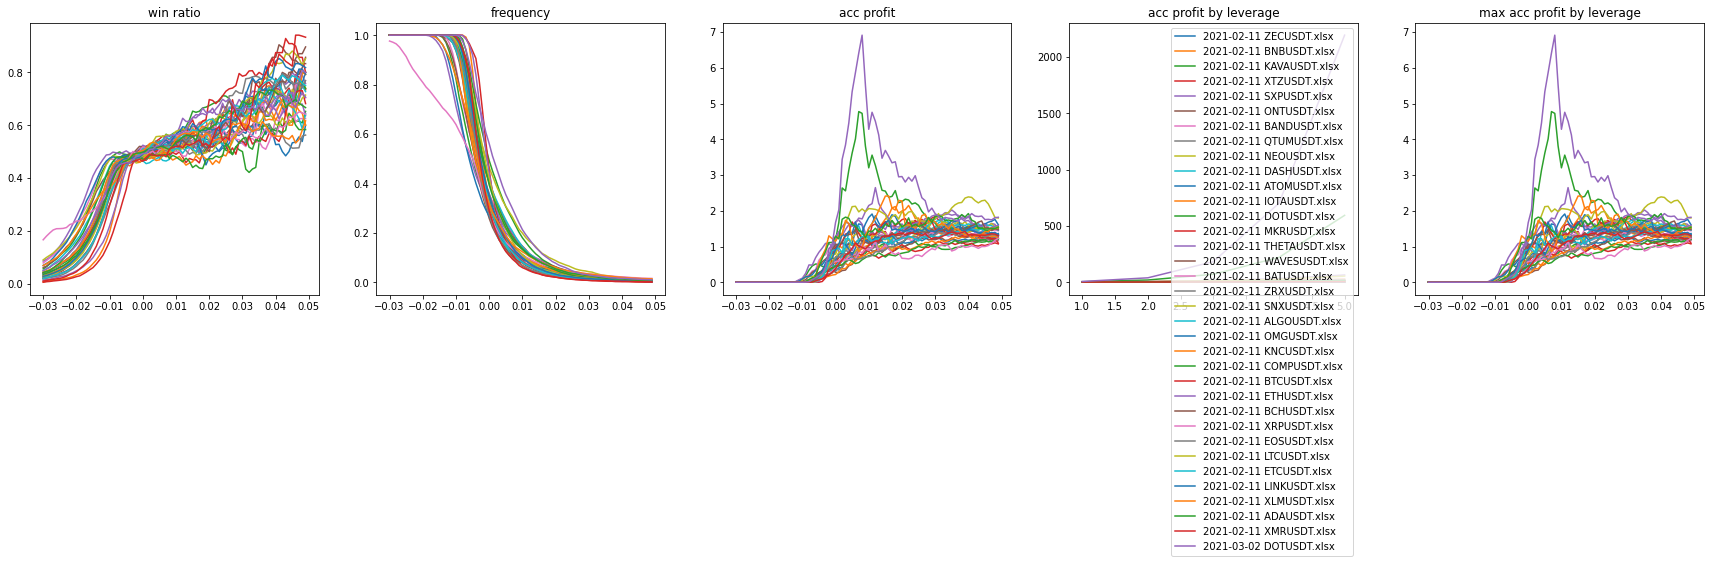

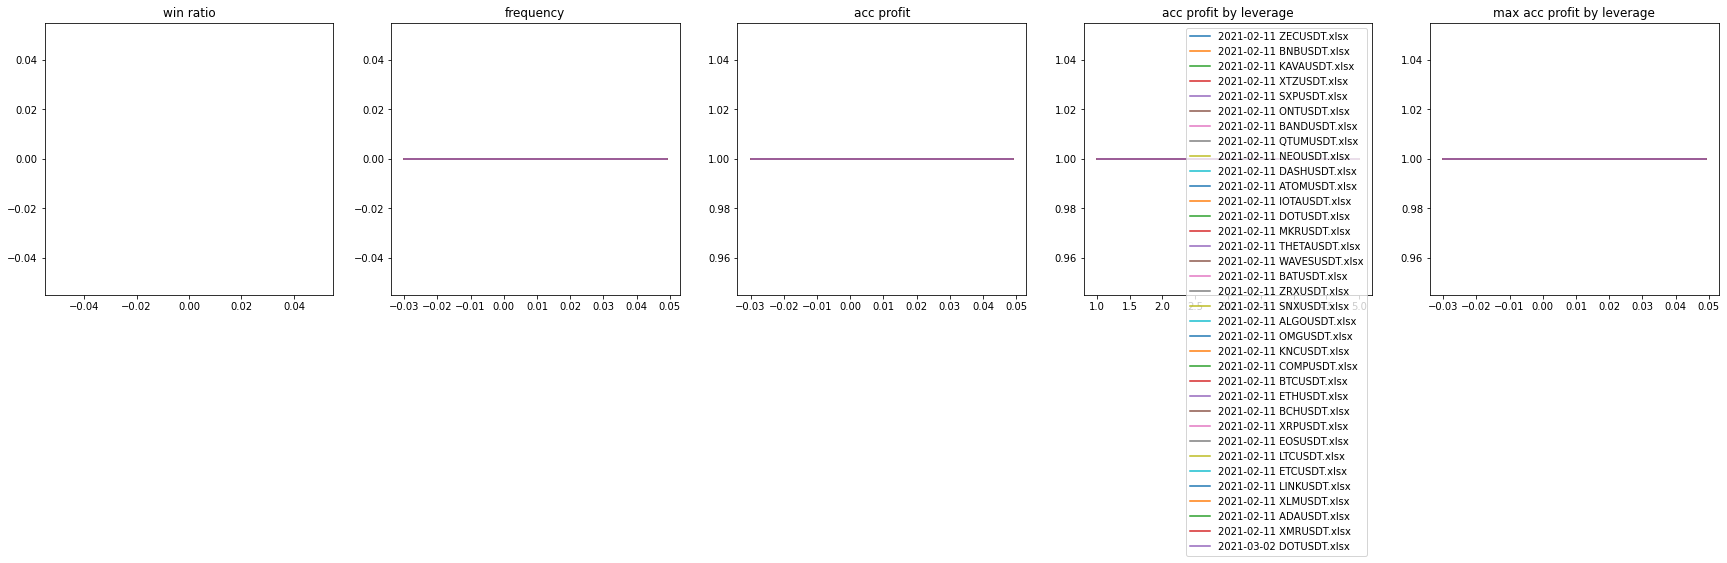

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
# print(type(result_dict))

with open('./arima_result/arima_profit_ls_only_long_result_%s.pickle' % interval, 'rb') as f:
# with open('./arima_result/arima_profit_ls_only_long_expanded_result_%s.pickle' % interval, 'rb') as f:
  profit_result_dict = pickle.load(f)

keys = profit_result_dict.keys()
print(keys)
# keys = ['2021-02-07 ETH.xlsx']
# break


for i in range(2):

  plt.figure(figsize=(30, 5))

  plt.subplot(151)
  plt.title('win ratio')  
  for key in keys:  
    # print(profit_result_dict[key]['wr_list'].shape)
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['wr_list'][:, [i]])


  plt.subplot(152)
  plt.title('frequency')  
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['fr_list'][:, [i]])

    
  plt.subplot(153)
  plt.title('acc profit')  
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['ap_list'][:, [i]])

  plt.subplot(155)
  plt.title('max acc profit by leverage')  
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['max_ap_list'][:, [i]], label=key)
    
  plt.subplot(154)
  plt.title('acc profit by leverage')  
  for key in keys:  
    plt.plot(profit_result_dict[key]['leverage_list'], profit_result_dict[key]['leverage_ap_list'][:, [i]], label=key)
    # print(result_dict[key]['leverage_ap_list'])
  plt.legend()

  plt.show()


### **Extract Candidate pairs**

In [6]:

pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 2500)

pairs = list(profit_result_dict.keys())
result_df = pd.DataFrame(index=pairs)
profit = list()
max_lv_profit = list()
pr_fr_std = list()
max_pr_fr_std = list()

long_index = 0

for key in keys:  
  # print(np.max(profit_result_dict[key]['ap_list']))
  profit.append(np.max(profit_result_dict[key]['ap_list'][:, [long_index]]))
  # print(np.max(profit_result_dict[key]['leverage_ap_list']))
  max_lv_profit.append(np.max(profit_result_dict[key]['leverage_ap_list'][:, [long_index]]))

  ohlcv = profit_result_dict[key]['ohlcv']
  predictions = profit_result_dict[key]['predictions']
  err_ranges = profit_result_dict[key]['err_ranges']
  
  #             편의를 위해 long position 분석만을 진행한다.           #
  argmax = np.argmax(profit_result_dict[key]['ap_list'][:, [long_index]])
  peak_tp = profit_result_dict[key]['tp_list'][argmax]

  result = get_back_result(ohlcv, predictions, err_ranges, tp=peak_tp, leverage=4)
  profit_list = result[3][long_index]
  pr_list_fr = list(map(lambda x : 0 if x == 1.0 else 1, profit_list))
  profited_index = np.argwhere(np.array(pr_list_fr) == 1)
  # print(profited_index)
  term_list = list()
  for i in range(len(profited_index) - 1):
    term_list.append(profited_index[i + 1] - profited_index[i])

  profit_result_dict[key]['pr_list'] = profit_list
  profit_result_dict[key]['pr_fr_std'] = np.std(term_list)
  pr_fr_std.append(np.std(term_list))

  argmax = np.argmax(profit_result_dict[key]['max_ap_list'][:, [long_index]])
  max_peak_tp = profit_result_dict[key]['tp_list'][argmax]

  result = get_back_result(ohlcv, predictions, err_ranges, tp=max_peak_tp, leverage=4)
  profit_list = result[3][long_index]
  pr_list_fr = list(map(lambda x : 0 if x == 1.0 else 1, profit_list))
  profited_index = np.argwhere(np.array(pr_list_fr) == 1)
  # print(profited_index)
  term_list = list()
  for i in range(len(profited_index) - 1):
    term_list.append(profited_index[i + 1] - profited_index[i])

  profit_result_dict[key]['max_pr_list'] = profit_list
  profit_result_dict[key]['max_pr_fr_std'] = np.std(term_list)
  max_pr_fr_std.append(np.std(term_list))


# result_df['index'] = pairs
result_df['profit']= profit
result_df['max_lv_profit']= max_lv_profit
result_df['pr_fr_std'] = pr_fr_std
result_df['max_pr_fr_std'] = max_pr_fr_std
# print(result_df)

#     sort by values    #
print(result_df.sort_values(by='profit', ascending=False))
print(result_df.sort_values(by=['max_lv_profit'], ascending=False))
print(result_df.sort_values(by=['pr_fr_std'], ascending=True))
print(result_df.sort_values(by=['max_pr_fr_std'], ascending=True))

#     extract candidates    #
candis = result_df.sort_values(by=['max_lv_profit'], ascending=False).index
print(candis)



#         save dict 2       #
# with open('./arima_result/arima_candi_profit_ls_only_long_result_%s.pickle' % interval, 'wb') as f:
#   pickle.dump(profit_result_dict, f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

                                         profit         max_lv_profit   pr_fr_std  max_pr_fr_std
2021-03-02 DOTUSDT.xlsx     [6.912900327851171]   [2192.467759465829]    4.228312       4.228312
2021-02-11 DOTUSDT.xlsx     [4.774926488384748]   [593.5552209932433]    6.273216       6.273216
2021-02-11 ETHUSDT.xlsx    [2.6473032437207706]   [64.34016336888222]   23.092821      23.092821
2021-02-11 XLMUSDT.xlsx    [2.4132189268051474]   [7.687335412071631]   34.021039      34.021039
2021-02-11 LTCUSDT.xlsx      [2.38787822488497]    [54.2720485020589]  136.777036     136.777036
2021-02-11 IOTAUSDT.xlsx    [2.148081724316156]  [27.019915710338736]   78.946221      78.946221
2021-02-11 THETAUSDT.xlsx  [2.0215465335196434]   [24.05447627263514]   91.511556      91.511556
2021-02-11 ADAUSDT.xlsx    [1.9210746147406672]   [16.10243214749977]  123.689633     123.689633
2021-02-11 SNXUSDT.xlsx    [1.9200880480260767]  [16.384824834706265]   34.825163      34.825163
2021-02-11 LINKUSDT.xlsx   [1.

### **Candi Result Analysis**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

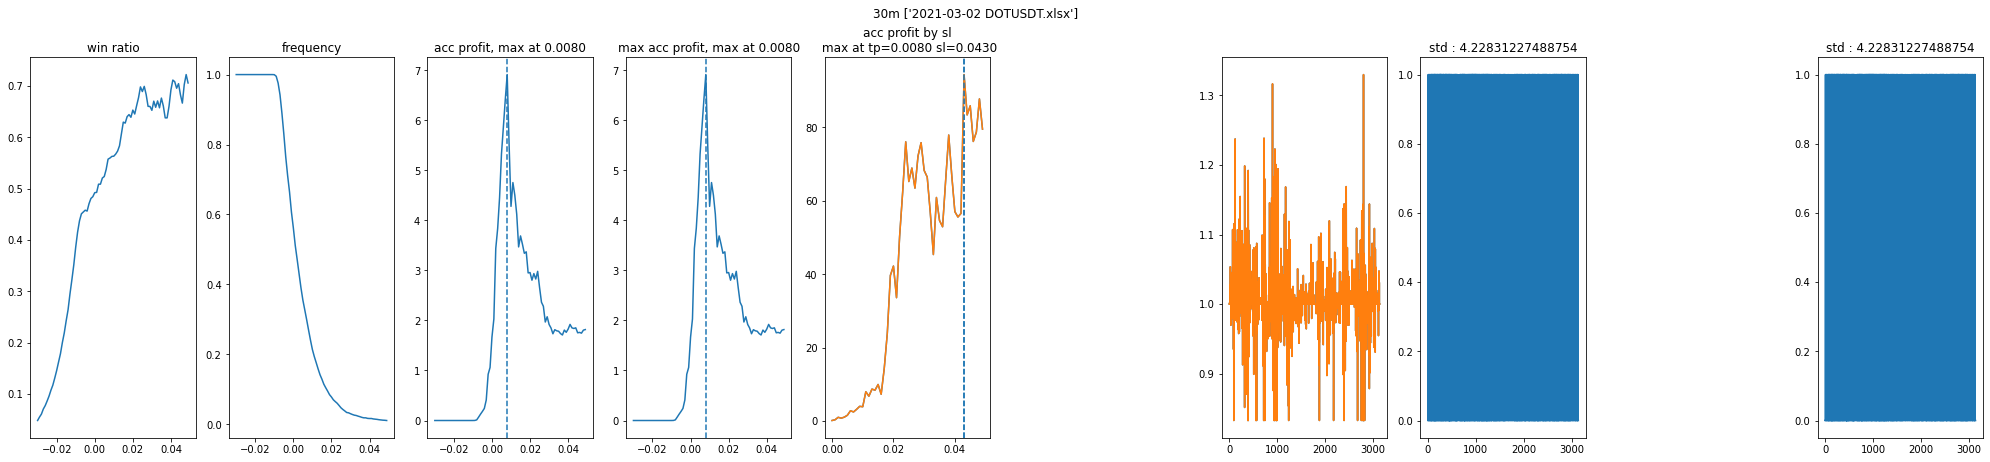

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

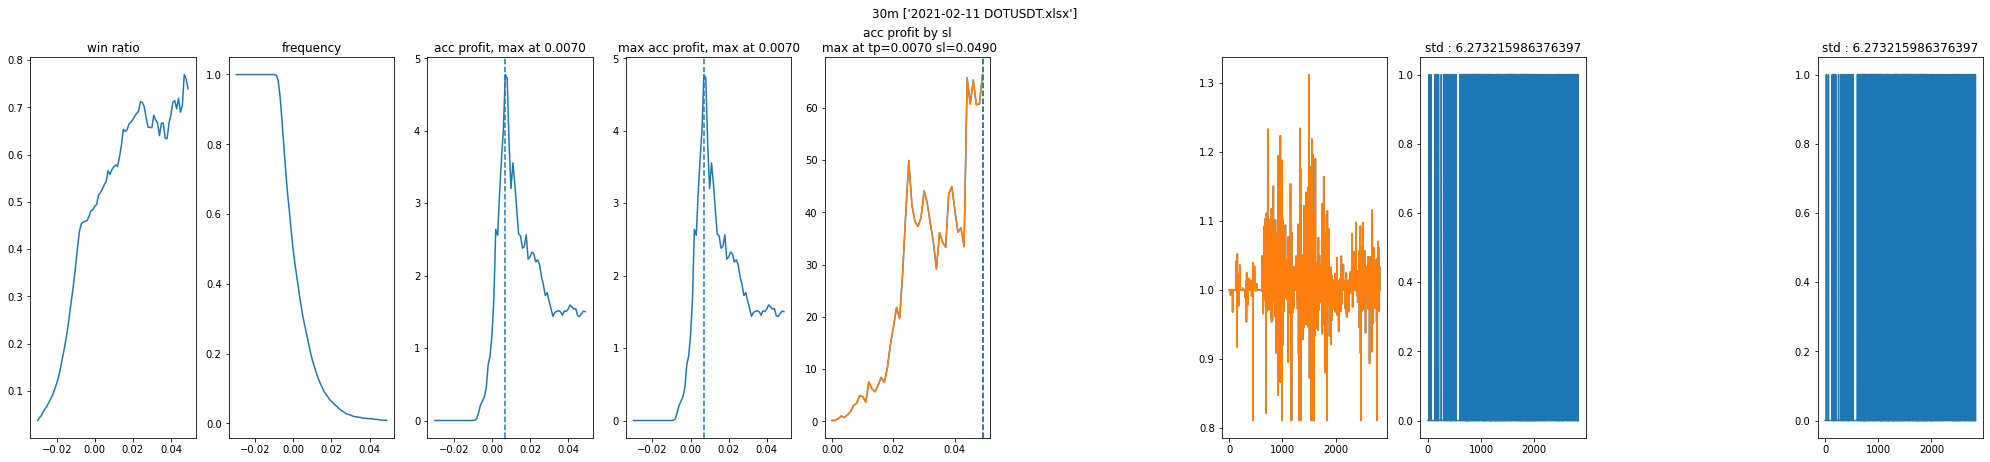

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

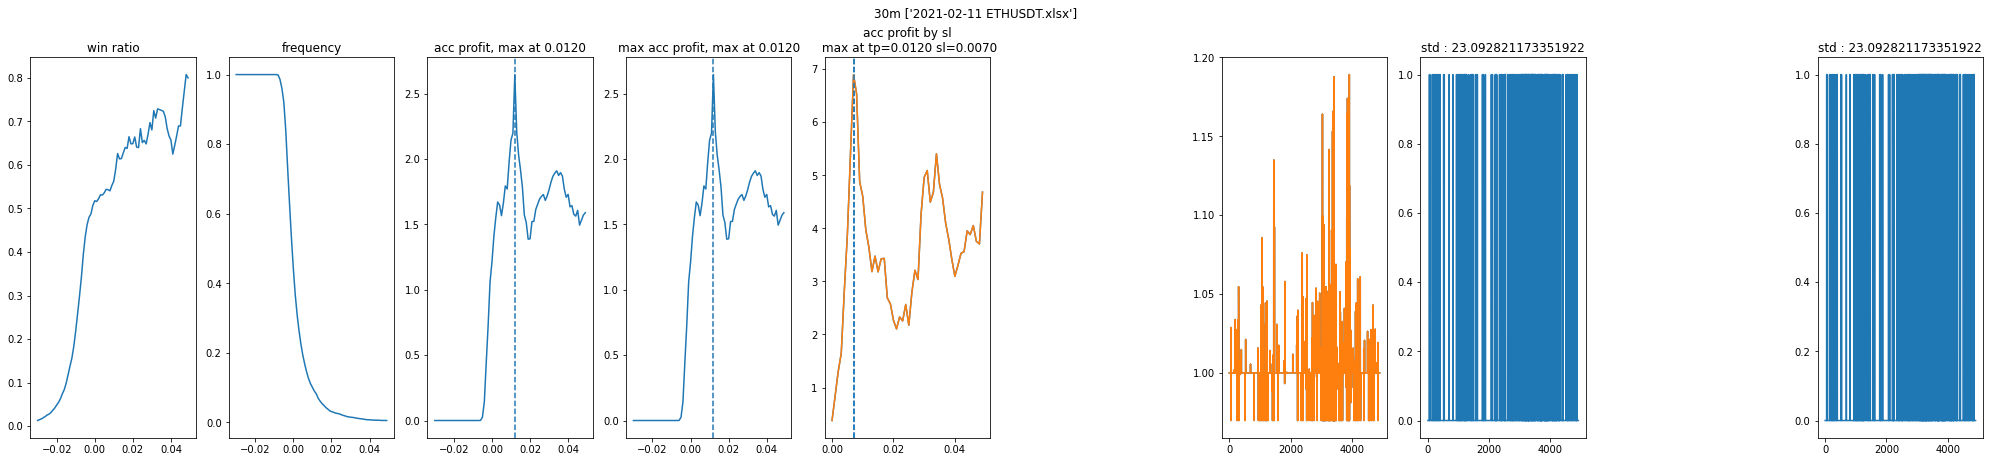

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

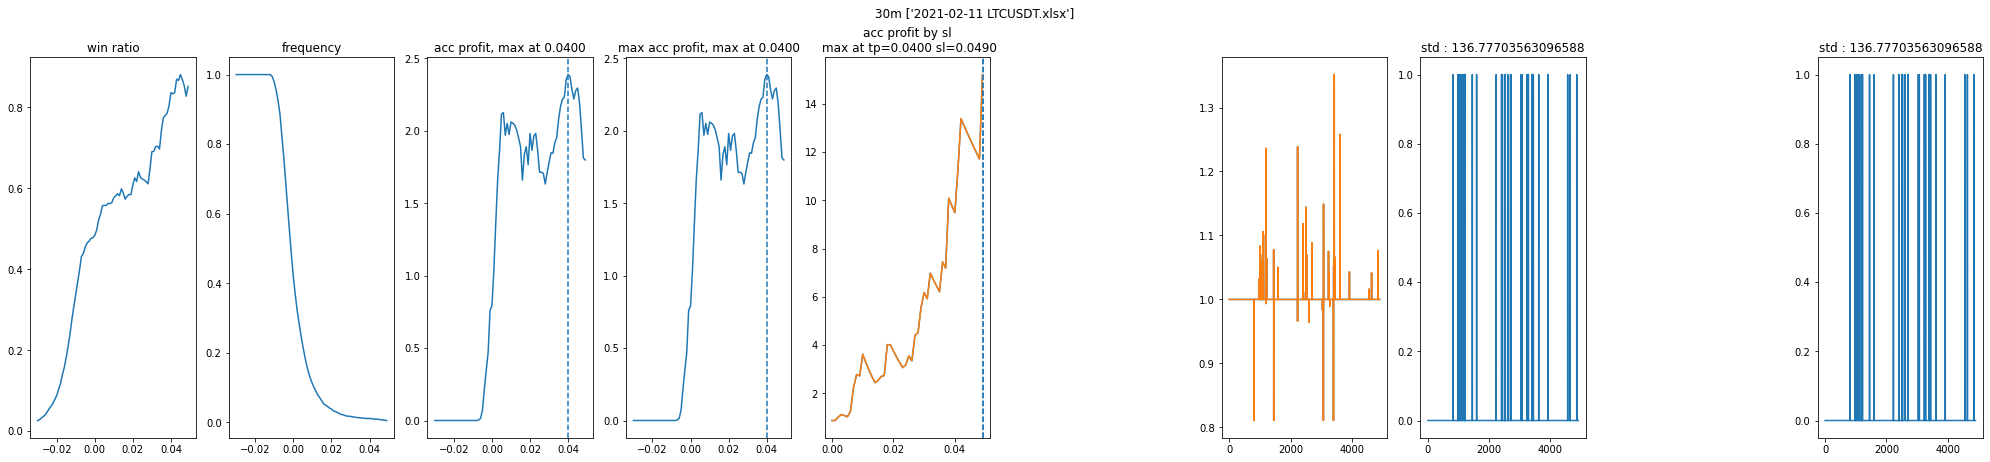

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

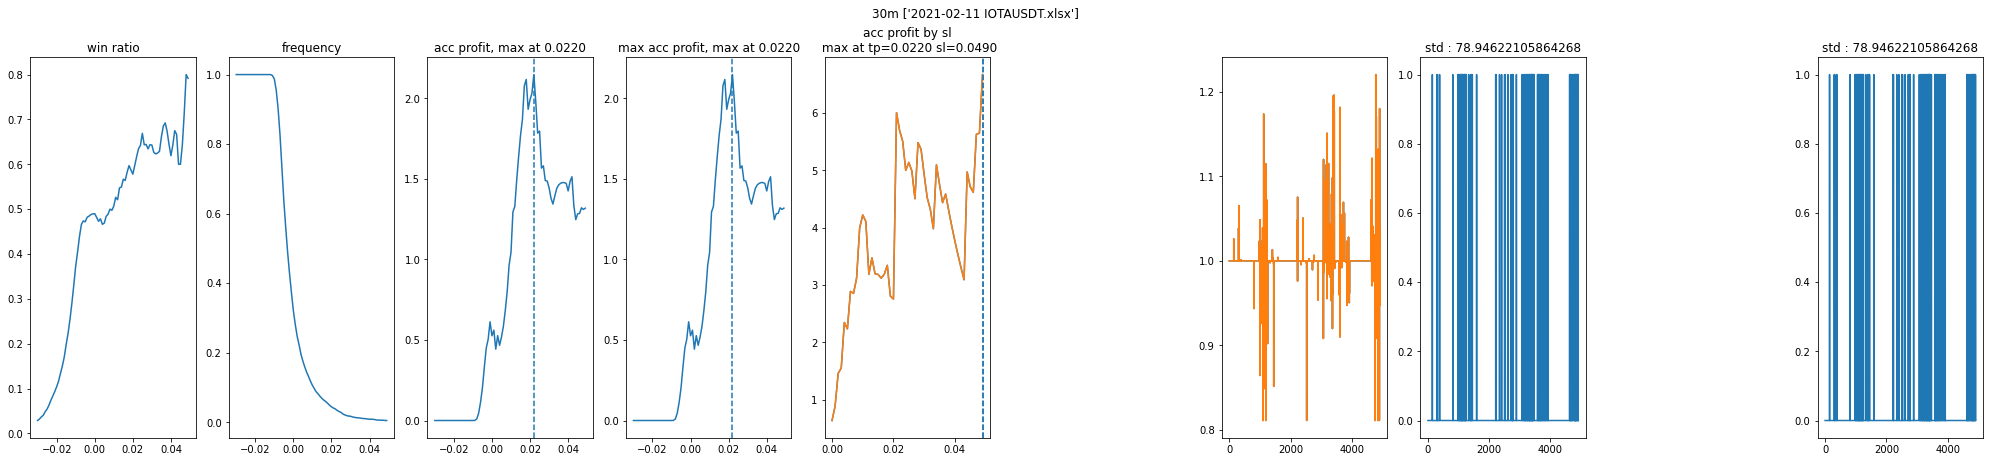

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

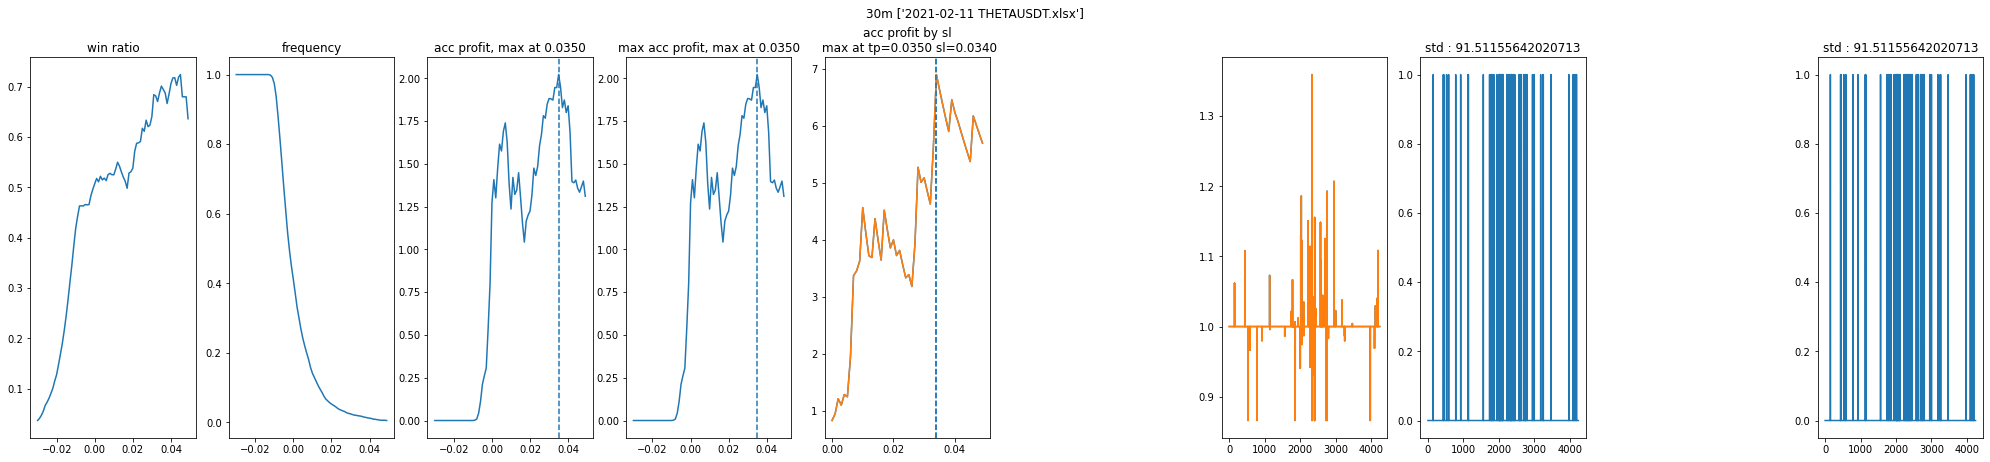

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

KeyboardInterrupt: ignored

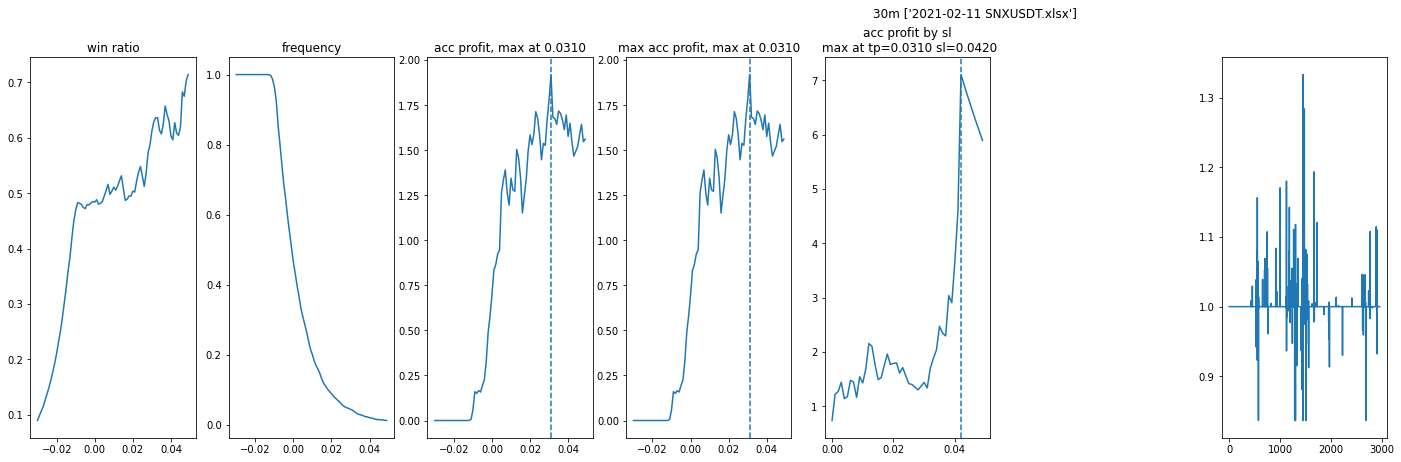

In [9]:
long_index = 0
safety_threshold = 0.6

sl_list = np.arange(0, 0.05, 0.001)


for i in range(len(candis)):

  keys = [candis[i]]

  plt.figure(figsize=(35, 7))
  plt.suptitle('%s %s' % (interval, keys))

  plt.subplot(1,10,1)
  plt.title('win ratio')  
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['wr_list'][:, [long_index]])


  plt.subplot(1,10,2)
  plt.title('frequency')  
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['fr_list'][:, [long_index]])

    
  plt.subplot(1,10,3)
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['ap_list'][:, [long_index]])
    argmax = np.argmax(profit_result_dict[key]['ap_list'][:, [long_index]])
    peak_tp = profit_result_dict[key]['tp_list'][argmax]
    plt.axvline(peak_tp, linestyle='--')
    plt.title('acc profit, max at %.4f' % (peak_tp))  

  plt.subplot(1,10,4)
  plt.title('max acc profit by leverage')  
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['max_ap_list'][:, [long_index]], label=key)
    argmax = np.argmax(profit_result_dict[key]['max_ap_list'][:, [long_index]])
    max_peak_tp = profit_result_dict[key]['tp_list'][argmax]
    plt.axvline(max_peak_tp, linestyle='--')
    plt.title('max acc profit, max at %.4f' % (max_peak_tp))  


  for key in keys:  
    # print(profit_result_dict[key]['leverage_ap_list'])

    for tp in [peak_tp, max_peak_tp]:

      if tp == peak_tp:
        plt.subplot(1,10,5)
      else:
        plt.subplot(1,10,6)

      #     leverage analysis     #
      ohlcv = profit_result_dict[key]['ohlcv']
      predictions = profit_result_dict[key]['predictions']
      err_ranges = profit_result_dict[key]['err_ranges']
      leverage_list = profit_result_dict[key]['leverage_list']
      temp_ap_list = list()
      temp_pr_list = list()

      # for leverage in leverage_list:
      for sl in sl_list:


        try:
          result = get_back_result(ohlcv, predictions, err_ranges, tp=tp, sl=sl, leverage=4, reverse_short=False)

          # if min(result[-1][long_index]) < safety_threshold:
          #   continue

          temp_ap_list.append(result[2][long_index])
          temp_pr_list.append(result[3][long_index])

          # if round(leverage) == 1:
          #   temp_pr_list = result[3]

        except Exception as e:
          print(e)
          break

      
      # profit_result_dict[key]['pr_list'] = temp_pr_list

      plt.plot(sl_list[:len(temp_ap_list)],temp_ap_list, label=key)
      argmax = np.argmax(temp_ap_list)
      plt.title('acc profit by sl\n max at tp=%.4f sl=%.4f' % (tp, sl_list[:len(temp_ap_list)][argmax]))  
      plt.axvline(sl_list[:len(temp_ap_list)][argmax], linestyle='--')

      if tp == peak_tp:
        plt.subplot(1,10,7)
      else:
        plt.subplot(1,10,9)

      plt.plot(temp_pr_list[argmax])
    # plt.xlim(0, 13)

    
  # plt.subplot(1,10,7)
  for key in keys:  
    pr_list = profit_result_dict[key]['pr_list']
    # plt.plot(pr_list)

    pr_fr_std = profit_result_dict[key]['pr_fr_std']
    pr_list_fr = list(map(lambda x : 0 if x == 1.0 else 1, pr_list))

    plt.subplot(1,10,8)
    plt.title('std : %s' % pr_fr_std)
    plt.plot(pr_list_fr)

  # plt.subplot(1,10,9)
  for key in keys:  
    pr_list = profit_result_dict[key]['max_pr_list']
    # plt.plot(pr_list)

    pr_fr_std = profit_result_dict[key]['max_pr_fr_std']
    pr_list_fr = list(map(lambda x : 0 if x == 1.0 else 1, pr_list))

    plt.subplot(1,10,10)
    plt.title('std : %s' % pr_fr_std)
    plt.plot(pr_list_fr)


  
  

  plt.show()

  

#### **RM - Maximum Loss**

-------------- 2021-02-11 ETHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

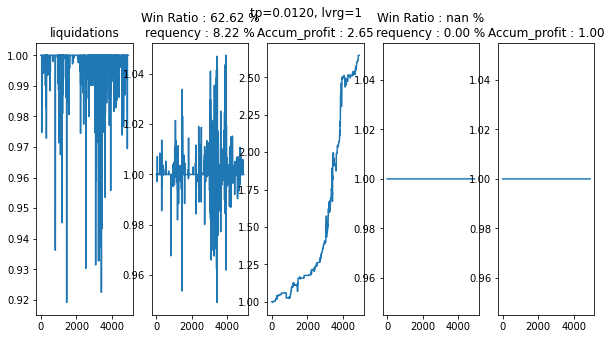

-------------- 2021-02-11 ETHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

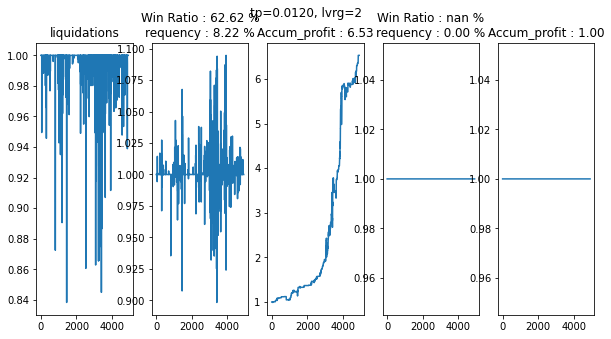

-------------- 2021-02-11 ETHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

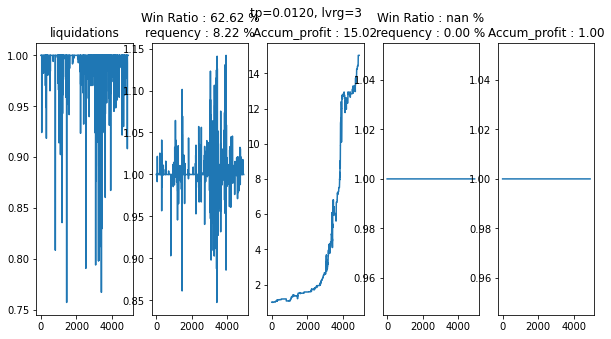

-------------- 2021-02-11 ETHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

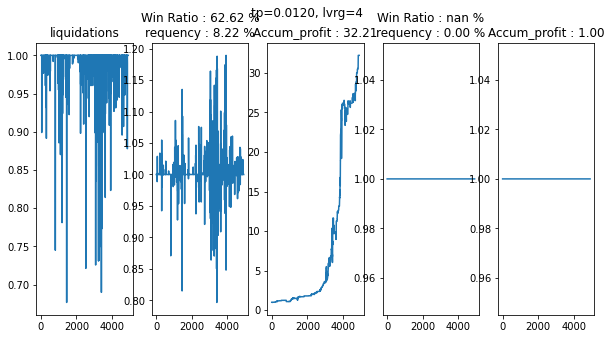

-------------- 2021-02-11 ETHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

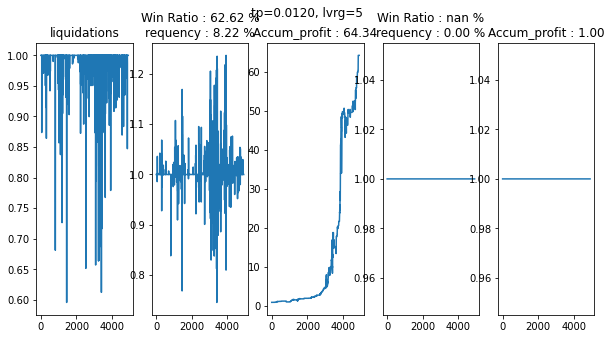

-------------- 2021-02-11 ETHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

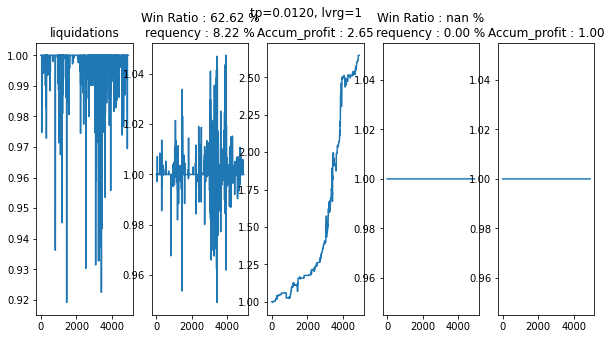

-------------- 2021-02-11 ETHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

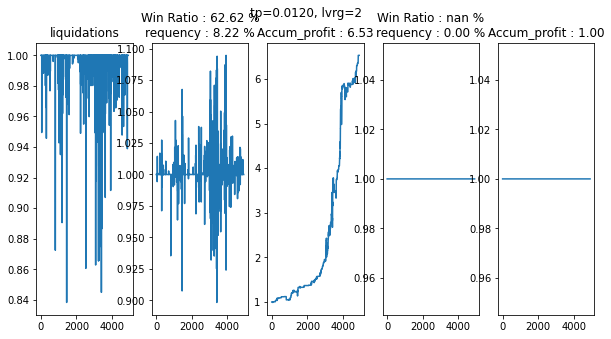

-------------- 2021-02-11 ETHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

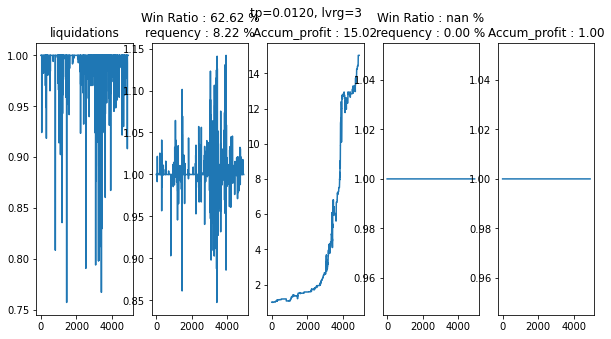

-------------- 2021-02-11 ETHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

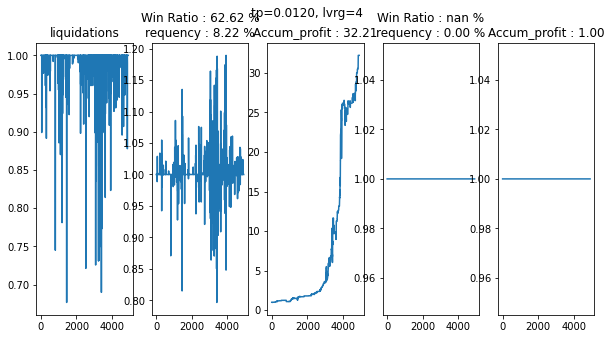

-------------- 2021-02-11 ETHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

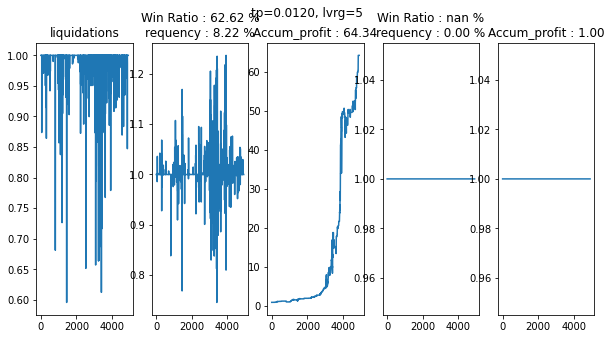

In [ ]:
leverage_list2 = np.arange(1, 6, 1)

for i in range(len(candis)):

  keys = [candis[i]]
  
  if 'eth'.upper() not in candis[i]:
    continue

  # plt.figure(figsize=(35, 10))
  # plt.suptitle('%s %s' % (interval, keys))

  # plt.subplot(1,10,3)
  for key in keys:  
    # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['ap_list'])
    argmax = np.argmax(profit_result_dict[key]['ap_list'][:, [long_index]])
    peak_tp = profit_result_dict[key]['tp_list'][argmax]
    # plt.axvline(peak_tp, linestyle='--')
    # plt.title('acc profit, max at %.4f' % (peak_tp))  

  # plt.subplot(1,10,4)
  # plt.title('max acc profit by leverage')  
  for key in keys:  
    # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['max_ap_list'], label=key)
    argmax = np.argmax(profit_result_dict[key]['max_ap_list'][:, [long_index]])
    max_peak_tp = profit_result_dict[key]['tp_list'][argmax]
    # plt.axvline(max_peak_tp, linestyle='--')
    # plt.title('max acc profit, max at %.4f' % (max_peak_tp))  


  for key in keys:  
    # print(profit_result_dict[key]['leverage_ap_list'])

    for tp in [peak_tp, max_peak_tp]:

      # if tp == peak_tp:
      #   plt.subplot(1,10,5)
      # else:
      #   plt.subplot(1,10,6)

      #     leverage analysis     #
      ohlcv = profit_result_dict[key]['ohlcv']
      predictions = profit_result_dict[key]['predictions']
      err_ranges = profit_result_dict[key]['err_ranges']
      # leverage_list = profit_result_dict[key]['leverage_list']
      # temp_ap_list = list()
      # temp_pr_list = list()

      for leverage in leverage_list2:

        try:
          print('-------------- %s --------------' % key)
          result = get_back_result(ohlcv, predictions, err_ranges, tp=tp, leverage=leverage, show_plot=True, reverse_short=False, show_detail=False)
          # temp_ap_list.append(result[2])
          # temp_pr_list.append(result[3])

          # if round(leverage) == 1:
          #   temp_pr_list = result[3]

        except Exception as e:
          print(e)
          break
        
  # break

  

### **Optimization : Classify**

In [ ]:

      
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import precision_score, recall_score, precision_recall_curve
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix


# from sklearn.utils.testing import all_estimators
# from sklearn.metrics import accuracy_score, classification_report

# from functools import partial
# from sklearn.utils import class_weight

# np.random.seed(1)
# tf.random.set_seed(1)

# # coin = 'dot'
# leverage = 3


# for i in range(len(candis)):

#   keys = [candis[i]]
  
#   # if 'algo'.upper() not in candis[i]:
#   #   continue
#   if '2021-02-11 DOTUSDT.xlsx' not in candis[i]:
#     continue

#   # plt.figure(figsize=(35, 10))
#   # plt.suptitle('%s %s' % (interval, keys))


#   #         get tp parameter        #

#   # plt.subplot(1,10,3)
#   # for key in keys:  
#   #   # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['ap_list'])
#   #   argmax = np.argmax(profit_result_dict[key]['ap_list'][:, [long_index]])
#   #   peak_tp = profit_result_dict[key]['tp_list'][argmax]
#   #   # plt.axvline(peak_tp, linestyle='--')
#   #   # plt.title('acc profit, max at %.4f' % (peak_tp))  

#   # plt.subplot(1,10,4)
#   # plt.title('max acc profit by leverage')  
#   for key in keys:  
#     # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['max_ap_list'], label=key)
#     argmax = np.argmax(profit_result_dict[key]['max_ap_list'][:, [long_index]])
#     max_peak_tp = profit_result_dict[key]['tp_list'][argmax]
#     # plt.axvline(max_peak_tp, linestyle='--')
#     # plt.title('max acc profit, max at %.4f' % (max_peak_tp))  


#   for key in keys:  
#     # print(profit_result_dict[key]['leverage_ap_list'])

#     for tp in [max_peak_tp]:

#       # if tp == peak_tp:
#       #   plt.subplot(1,10,5)
#       # else:
#       #   plt.subplot(1,10,6)

#       #     leverage analysis     #
#       ohlcv = profit_result_dict[key]['ohlcv']
#       predictions = profit_result_dict[key]['predictions']
#       err_ranges = profit_result_dict[key]['err_ranges']

#       # predictions = ohlcv['close'].shift(1).values
#       # err_ranges = np.zeros_like(predictions)

#       leverage_list = profit_result_dict[key]['leverage_list']
#       # temp_ap_list = list()
#       # temp_pr_list = list()

#       try:
#         print('-------------- %s --------------' % key)
#         result = get_back_result(ohlcv, predictions, err_ranges, tp=tp, leverage=leverage, show_plot=True, reverse_short=False, show_detail=False)
#         # temp_ap_list.append(result[2])
#         # temp_pr_list.append(result[3])

#         # if round(leverage) == 1:
#         #   temp_pr_list = result[3]
#         pr_list = result[3][long_index]

#       except Exception as e:
#         print(e)
#         break    
#   # break

#       from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

#       pd.set_option('display.max_rows', 500)
#       pd.set_option('display.max_columns', 500)
#       pd.set_option('display.width', 1000)

#       #         clustering zone           #

#       #       set data features : ohlc, v, ep
#       ohlc = ohlcv.iloc[-len(predictions):, :4]
#       vol = ohlcv.iloc[-len(predictions):, [4]]
#       long_ep = (np.array(predictions) - np.array(err_ranges)) * (1 / (tp + 1))
#       long_ep = long_ep.reshape(-1, 1)

#       ohlcv['u_wick'] = ohlcv['high'] / np.maximum(ohlcv['close'] , ohlcv['open'])
#       ohlcv['d_wick'] = np.minimum(ohlcv['close'] , ohlcv['open']) / ohlcv['low']
#       ohlcv['body'] = ohlcv['close'] / ohlcv['open']

#       candle = ohlcv.iloc[-len(predictions):, -3:]


#       print('len(ohlc) :', len(ohlc))
#       print('long_ep.shape :', long_ep.shape)
#       print('len(pr_list) :', len(pr_list))


#       #       set params    #
#       period = 5
#       data_x, data_pr, data_updown = [], [], []

#       for i in range(period, len(predictions)):

#         #   pr_list != 1 인 데이터만 사용한다
#         # if 1:
#         if pr_list[i] != 1:
          
#           #   prediction 을 제외한 이전 데이터를 사용해야한다
#           temp_ohlc = ohlc.iloc[i - period : i].values
#           temp_long_ep = long_ep[i - period : i]
#           temp_vol = vol.iloc[i - period : i].values
#           temp_candle = candle.iloc[i - period : i].values

#           # print(temp_ohlc.shape)
#           # print(temp_long_ep.shape)
#           # print(temp_vol.shape)
#           # print(temp_candle.shape)
#           # break

#           #   stacking  
#           # temp_data = np.hstack((temp_ohlc, temp_long_ep, temp_vol, temp_candle))
#           temp_data = np.hstack((temp_ohlc, temp_long_ep, temp_vol))
#           # temp_data = np.hstack((temp_ohlc, temp_long_ep))
#           # temp_data = temp_vol

#           #   scaler 설정

#           #   ohlc & ep -> max_abs
#           # max_abs = MaxAbsScaler()
#           # temp_data[:, :5] = max_abs.fit_transform(temp_data[:, :5])


#           min_max = MinMaxScaler()
#           temp_data[:, :5] = min_max.fit_transform(temp_data[:, :5])


#           #   vol -> min_max
#           min_max = MinMaxScaler()
#           temp_data[:, [5]] = min_max.fit_transform(temp_data[:, [5]])


#           #   candle -> max_abs    
#           # max_abs = MaxAbsScaler()
#           # temp_data[:, -3:] = max_abs.fit_transform(temp_data[:, -3:])

#           # min_max = MinMaxScaler()
#           # temp_data[:, -3:] = min_max.fit_transform(temp_data[:, -3:])

#           if np.isnan(np.sum(temp_data)):
#             continue

#           data_x.append(temp_data)
#           data_pr.append(pr_list[i])
#           data_updown.append(ohlc['close'].iloc[i] / ohlc['open'].iloc[i])


#       print('np.array(data_x).shape :', np.array(data_x).shape)
#       # print(data_x[0])


#       #       Reshape data for image deep - learning     #
#       _, row, col = np.array(data_x).shape

#       input_x = np.array(data_x).reshape(-1, row, col, 1).astype(np.float32)

#       #     1c to 3c    #
#       input_x = input_x * np.ones(3, dtype=np.float32)[None, None, None, :]

#       input_pr = np.array(data_pr).reshape(-1, 1).astype(np.float32)
#       input_ud = np.array(data_updown).reshape(-1, 1).astype(np.float32)
#       print('input_x.shape :', input_x.shape)
#       print('input_x.dtype :', input_x.dtype)
#       print('input_pr.shape :', input_pr.shape)
#       print('input_ud.shape :', input_ud.shape)

#       # break


#       #       check input     #
#       for i in range(len(input_x)):
#         plt.imshow(input_x[i])
#         plt.axis('off')
#         plt.show()
#         break


#       #         train / test split      #
#       x_train, x_test_, pr_train, pr_test_, ud_train, ud_test_ = train_test_split(input_x, input_pr, input_ud, test_size=0.4, shuffle=True, random_state=124)
#       x_test, x_val, pr_test, pr_val, ud_test, ud_val = train_test_split(x_test_, pr_test_, ud_test_, test_size=0.5, shuffle=True, random_state=124)


#       #         pr label   #
#       # y_train = np.where(pr_train > 1, 1, 0).astype(np.float32)
#       # y_test = np.where(pr_test > 1, 1, 0).astype(np.float32)
#       # y_val = np.where(pr_val > 1, 1, 0).astype(np.float32)

#       #         up label      #
#       y_train = np.where(ud_train > 1, 1, 0).astype(np.float32)
#       y_test = np.where(ud_test > 1, 1, 0).astype(np.float32)
#       y_val = np.where(ud_val > 1, 1, 0).astype(np.float32)

#       print('pr_train[:5] :', pr_train[:5])
#       print('ud_train[:5] :', ud_train[:5])
#       print('y_train[:5] :', y_train[:5])
#       print('y_train.dtype :', y_train.dtype)

#       print('x_train.shape :', x_train.shape)
#       print('x_test.shape :', x_test.shape)
#       print('x_val.shape :', x_val.shape)
#       print('y_train.shape :', y_train.shape)
#       print('y_test.shape :', y_test.shape)
#       print('y_val.shape :', y_val.shape)

#       print('np.unique(y_train, return_counts=True :', np.unique(y_train, return_counts=True))
#       print('np.unique(y_val, return_counts=True :', np.unique(y_val, return_counts=True))

#       label = y_train.reshape(-1, )
#       class_weights = class_weight.compute_class_weight('balanced', 
#                                                           classes=np.unique(label),
#                                                           y=label)
#       class_weights = dict(enumerate(class_weights))
#       print('class_weights :', class_weights)

#       print('np.isnan(np.sum(x_train)) :', np.isnan(np.sum(x_train)))
#       print('np.isnan(np.sum(y_train)) :', np.isnan(np.sum(y_train)))


#       train_set_ = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#       test_set_ = tf.data.Dataset.from_tensor_slices((x_test, y_test))
#       val_set_ = tf.data.Dataset.from_tensor_slices((x_val, y_val))

#       resize_shape = [row * 2, col * 2]
#       # resize_shape = [224, 224]

#       def preprocess(image, label, flip=False):
#         if flip:
#             flipped_image = tf.image.random_flip_left_right(image)
#             resized_image = tf.image.resize(flipped_image, resize_shape)
#         else:
#             resized_image = tf.image.resize(image, resize_shape)
#         final_image = keras.applications.xception.preprocess_input(resized_image * 255)
#         return  final_image, label

#       # Batch Size
#       batch_size = 32
      
#       train_set = train_set_.shuffle(1000).repeat(2)
#       train_set = train_set.map(partial(preprocess, flip=False)).batch(batch_size).prefetch(1)
#       val_set = val_set_.map(preprocess).batch(batch_size).prefetch(1)
#       test_set = test_set_.map(preprocess).batch(batch_size).prefetch(1)

#       # print('test_set[0] :', test_set[0])
#       # print('len(train_set) :', len(train_set))
      
#       for set in train_set:
#         print(set[0].numpy()[0].shape)
#         plt.imshow(set[0].numpy()[0, :, :, 0])
#         break

#       break

#### **Data stacking**

-------------- 2021-02-11 DOTUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

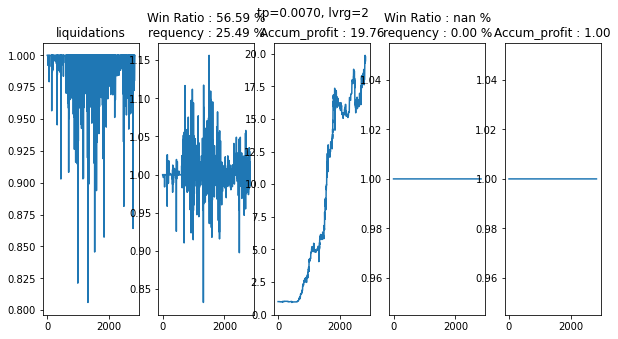

len(ohlc) : 2829
long_ep.shape : (2829, 1)
len(pr_list) : 2829
np.array(data_x).shape : (720, 5, 6)
input_x.shape : (720, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (720, 1)
input_ud.shape : (720, 1)
-------------- 2021-02-11 ETHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

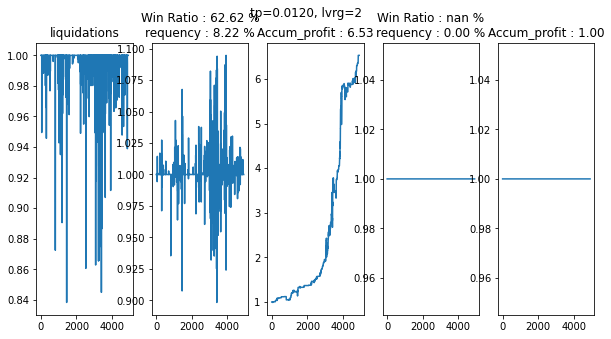

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (404, 5, 6)
input_x.shape : (404, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (404, 1)
input_ud.shape : (404, 1)
total_x.shape : (1124, 5, 6, 3)
total_pr.shape : (1124, 1)
total_ud.shape : (1124, 1)
-------------- 2021-02-11 LTCUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

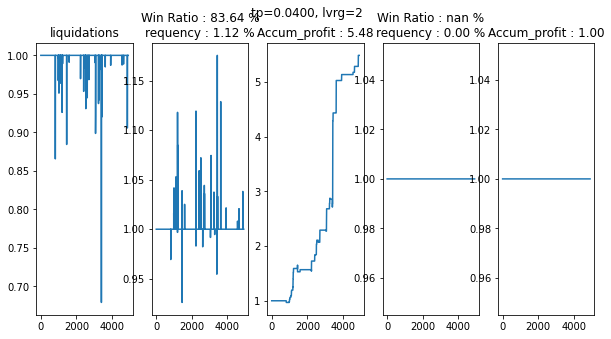

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (55, 5, 6)
input_x.shape : (55, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (55, 1)
input_ud.shape : (55, 1)
total_x.shape : (1179, 5, 6, 3)
total_pr.shape : (1179, 1)
total_ud.shape : (1179, 1)
-------------- 2021-02-11 IOTAUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

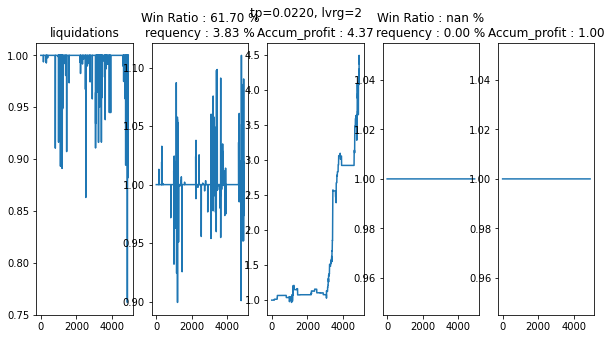

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (188, 5, 6)
input_x.shape : (188, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (188, 1)
input_ud.shape : (188, 1)
total_x.shape : (1367, 5, 6, 3)
total_pr.shape : (1367, 1)
total_ud.shape : (1367, 1)
-------------- 2021-02-11 THETAUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

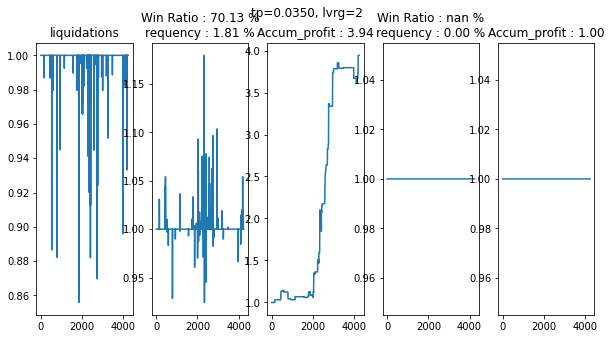

len(ohlc) : 4248
long_ep.shape : (4248, 1)
len(pr_list) : 4248
np.array(data_x).shape : (77, 5, 6)
input_x.shape : (77, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (77, 1)
input_ud.shape : (77, 1)
total_x.shape : (1444, 5, 6, 3)
total_pr.shape : (1444, 1)
total_ud.shape : (1444, 1)
-------------- 2021-02-11 SNXUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

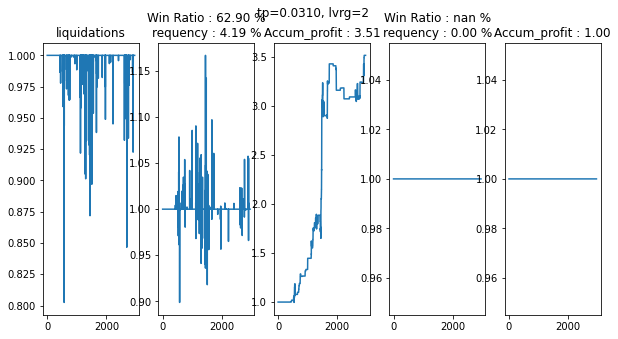

len(ohlc) : 2960
long_ep.shape : (2960, 1)
len(pr_list) : 2960
np.array(data_x).shape : (124, 5, 6)
input_x.shape : (124, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (124, 1)
input_ud.shape : (124, 1)
total_x.shape : (1568, 5, 6, 3)
total_pr.shape : (1568, 1)
total_ud.shape : (1568, 1)
-------------- 2021-02-11 ADAUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

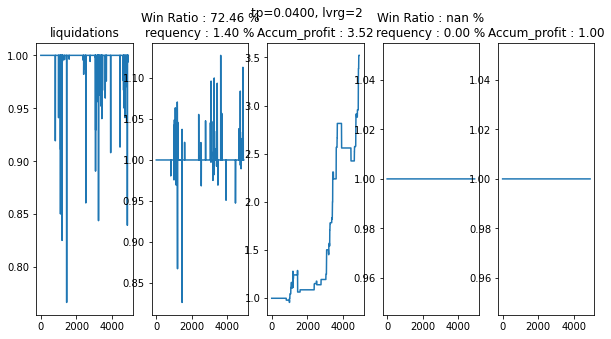

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (69, 5, 6)
input_x.shape : (69, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (69, 1)
input_ud.shape : (69, 1)
total_x.shape : (1637, 5, 6, 3)
total_pr.shape : (1637, 1)
total_ud.shape : (1637, 1)
-------------- 2021-02-11 BTCUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

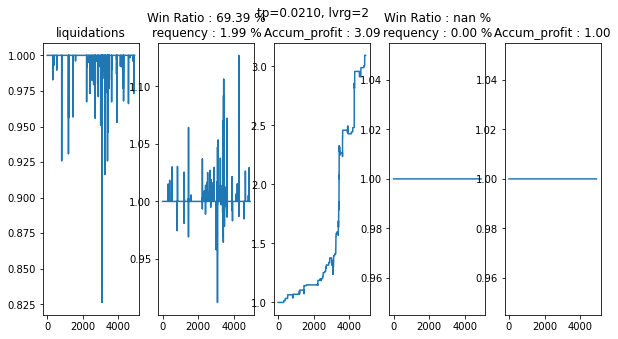

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (98, 5, 6)
input_x.shape : (98, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (98, 1)
input_ud.shape : (98, 1)
total_x.shape : (1735, 5, 6, 3)
total_pr.shape : (1735, 1)
total_ud.shape : (1735, 1)
-------------- 2021-02-11 ALGOUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

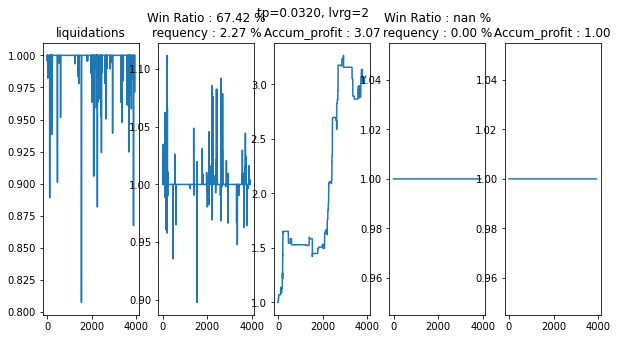

len(ohlc) : 3921
long_ep.shape : (3921, 1)
len(pr_list) : 3921
np.array(data_x).shape : (88, 5, 6)
input_x.shape : (88, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (88, 1)
input_ud.shape : (88, 1)
total_x.shape : (1823, 5, 6, 3)
total_pr.shape : (1823, 1)
total_ud.shape : (1823, 1)
-------------- 2021-02-11 OMGUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

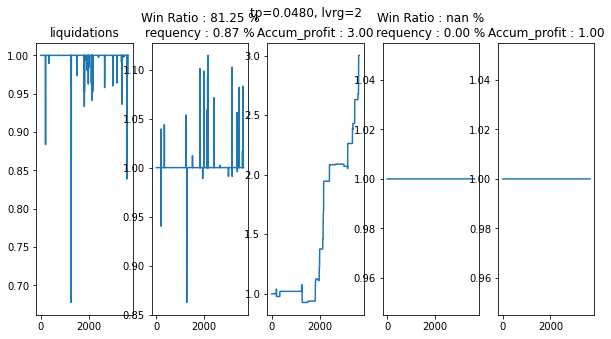

len(ohlc) : 3660
long_ep.shape : (3660, 1)
len(pr_list) : 3660
np.array(data_x).shape : (32, 5, 6)
input_x.shape : (32, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (32, 1)
input_ud.shape : (32, 1)
total_x.shape : (1855, 5, 6, 3)
total_pr.shape : (1855, 1)
total_ud.shape : (1855, 1)
-------------- 2021-02-11 BCHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

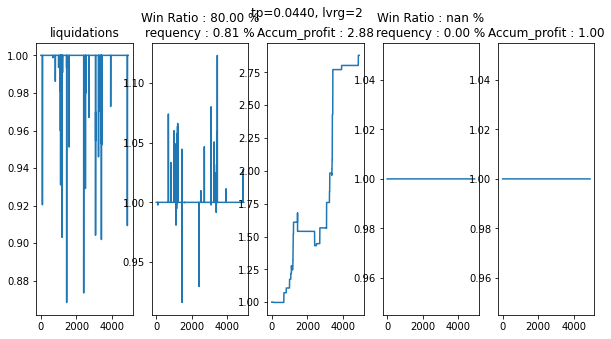

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (40, 5, 6)
input_x.shape : (40, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (40, 1)
input_ud.shape : (40, 1)
total_x.shape : (1895, 5, 6, 3)
total_pr.shape : (1895, 1)
total_ud.shape : (1895, 1)
-------------- 2021-02-11 XTZUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

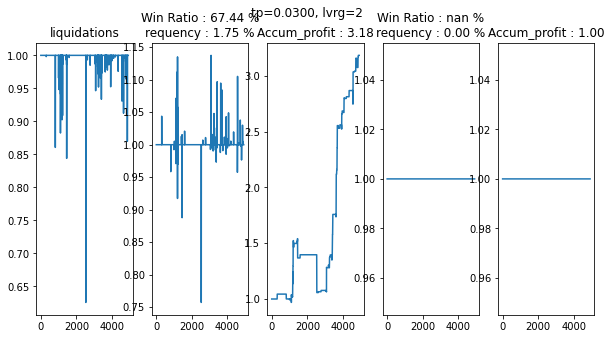

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (86, 5, 6)
input_x.shape : (86, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (86, 1)
input_ud.shape : (86, 1)
total_x.shape : (1981, 5, 6, 3)
total_pr.shape : (1981, 1)
total_ud.shape : (1981, 1)
-------------- 2021-02-11 DASHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

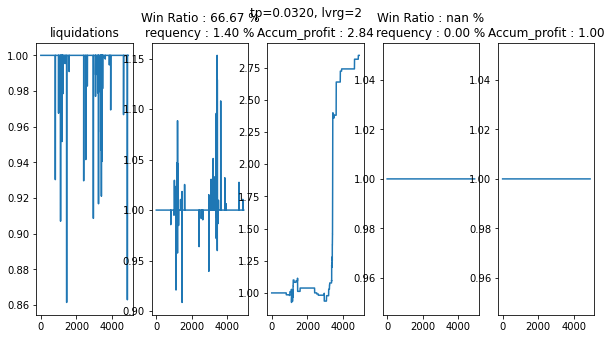

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (69, 5, 6)
input_x.shape : (69, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (69, 1)
input_ud.shape : (69, 1)
total_x.shape : (2050, 5, 6, 3)
total_pr.shape : (2050, 1)
total_ud.shape : (2050, 1)
-------------- 2021-02-11 QTUMUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

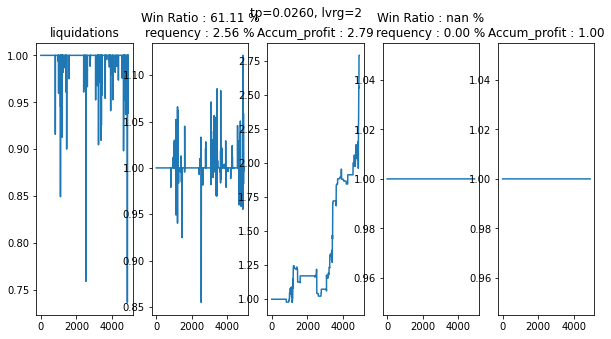

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (126, 5, 6)
input_x.shape : (126, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (126, 1)
input_ud.shape : (126, 1)
total_x.shape : (2176, 5, 6, 3)
total_pr.shape : (2176, 1)
total_ud.shape : (2176, 1)
-------------- 2021-02-11 NEOUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

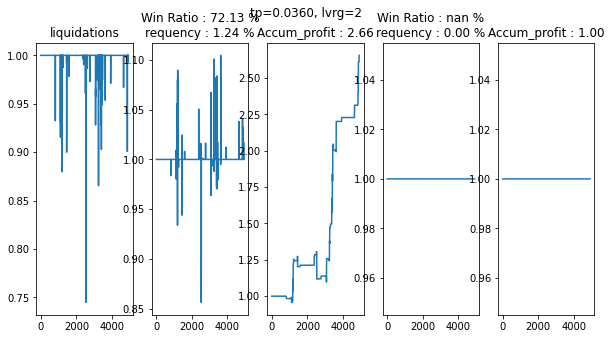

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (61, 5, 6)
input_x.shape : (61, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (61, 1)
input_ud.shape : (61, 1)
total_x.shape : (2237, 5, 6, 3)
total_pr.shape : (2237, 1)
total_ud.shape : (2237, 1)
-------------- 2021-02-11 ZRXUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

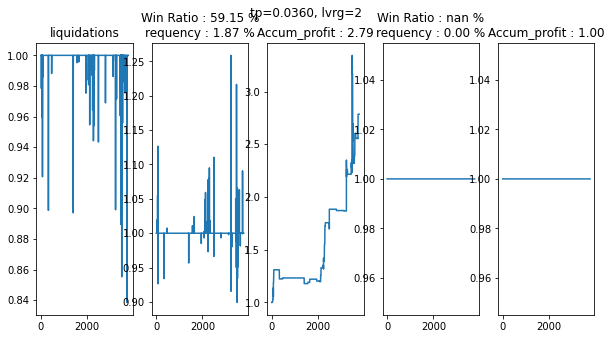

len(ohlc) : 3791
long_ep.shape : (3791, 1)
len(pr_list) : 3791
np.array(data_x).shape : (71, 5, 6)
input_x.shape : (71, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (71, 1)
input_ud.shape : (71, 1)
total_x.shape : (2308, 5, 6, 3)
total_pr.shape : (2308, 1)
total_ud.shape : (2308, 1)
-------------- 2021-02-11 XLMUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

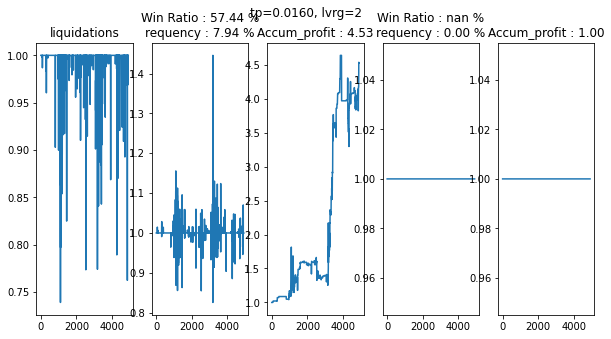

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (390, 5, 6)
input_x.shape : (390, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (390, 1)
input_ud.shape : (390, 1)
total_x.shape : (2698, 5, 6, 3)
total_pr.shape : (2698, 1)
total_ud.shape : (2698, 1)
-------------- 2021-02-11 ZECUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

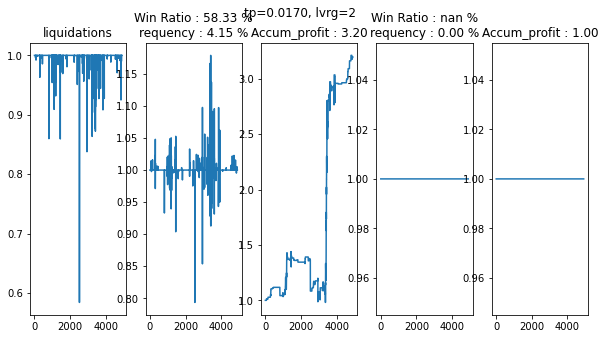

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (204, 5, 6)
input_x.shape : (204, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (204, 1)
input_ud.shape : (204, 1)
total_x.shape : (2902, 5, 6, 3)
total_pr.shape : (2902, 1)
total_ud.shape : (2902, 1)
-------------- 2021-02-11 BNBUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

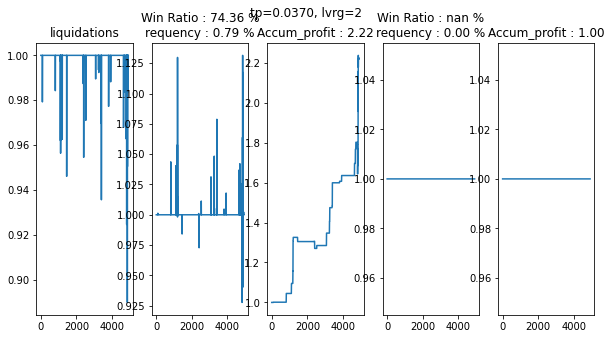

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (39, 5, 6)
input_x.shape : (39, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (39, 1)
input_ud.shape : (39, 1)
total_x.shape : (2941, 5, 6, 3)
total_pr.shape : (2941, 1)
total_ud.shape : (2941, 1)
-------------- 2021-02-11 BANDUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

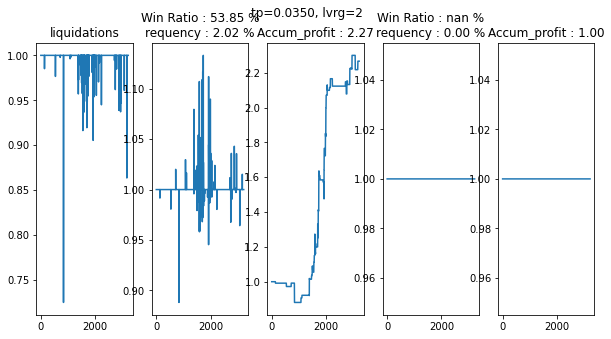

len(ohlc) : 3221
long_ep.shape : (3221, 1)
len(pr_list) : 3221
np.array(data_x).shape : (65, 5, 6)
input_x.shape : (65, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (65, 1)
input_ud.shape : (65, 1)
total_x.shape : (3006, 5, 6, 3)
total_pr.shape : (3006, 1)
total_ud.shape : (3006, 1)
-------------- 2021-02-11 WAVESUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

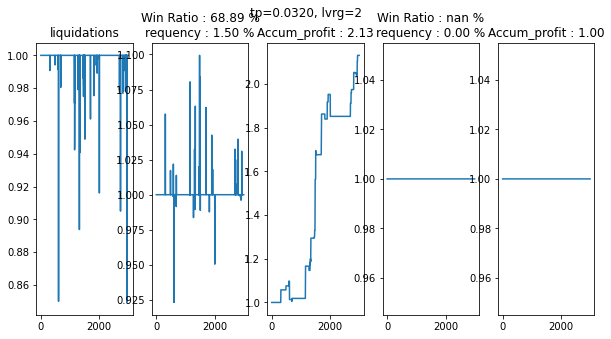

len(ohlc) : 2992
long_ep.shape : (2992, 1)
len(pr_list) : 2992
np.array(data_x).shape : (45, 5, 6)
input_x.shape : (45, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (45, 1)
input_ud.shape : (45, 1)
total_x.shape : (3051, 5, 6, 3)
total_pr.shape : (3051, 1)
total_ud.shape : (3051, 1)
-------------- 2021-02-11 ETCUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

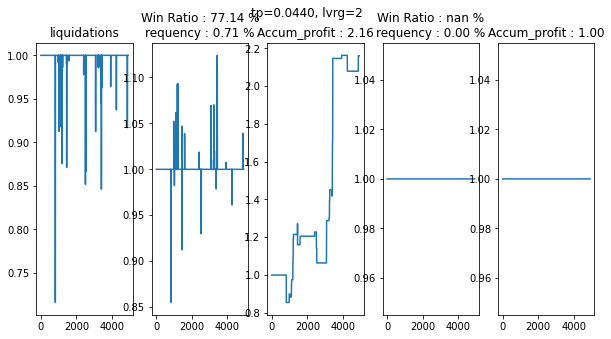

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (35, 5, 6)
input_x.shape : (35, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (35, 1)
input_ud.shape : (35, 1)
total_x.shape : (3086, 5, 6, 3)
total_pr.shape : (3086, 1)
total_ud.shape : (3086, 1)
-------------- 2021-02-11 BATUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

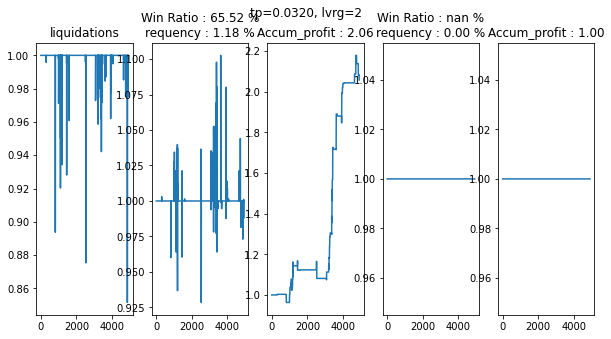

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (58, 5, 6)
input_x.shape : (58, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (58, 1)
input_ud.shape : (58, 1)
total_x.shape : (3144, 5, 6, 3)
total_pr.shape : (3144, 1)
total_ud.shape : (3144, 1)
-------------- 2021-02-11 LINKUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

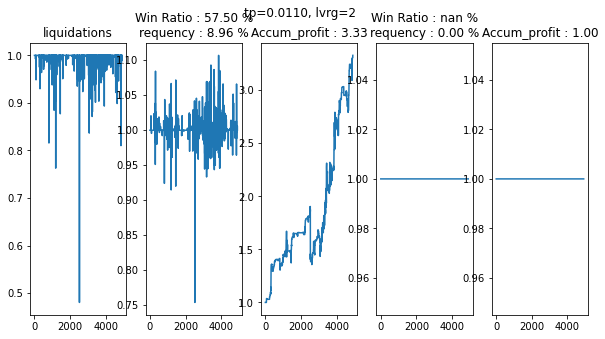

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (440, 5, 6)
input_x.shape : (440, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (440, 1)
input_ud.shape : (440, 1)
total_x.shape : (3584, 5, 6, 3)
total_pr.shape : (3584, 1)
total_ud.shape : (3584, 1)
-------------- 2021-02-11 XMRUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

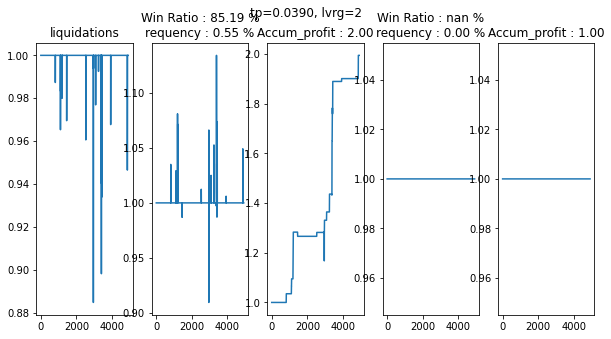

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (27, 5, 6)
input_x.shape : (27, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (27, 1)
input_ud.shape : (27, 1)
total_x.shape : (3611, 5, 6, 3)
total_pr.shape : (3611, 1)
total_ud.shape : (3611, 1)
-------------- 2021-02-11 SXPUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

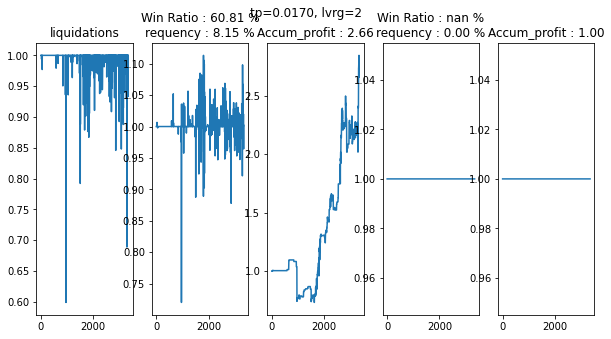

len(ohlc) : 3350
long_ep.shape : (3350, 1)
len(pr_list) : 3350
np.array(data_x).shape : (273, 5, 6)
input_x.shape : (273, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (273, 1)
input_ud.shape : (273, 1)
total_x.shape : (3884, 5, 6, 3)
total_pr.shape : (3884, 1)
total_ud.shape : (3884, 1)
-------------- 2021-02-11 KNCUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

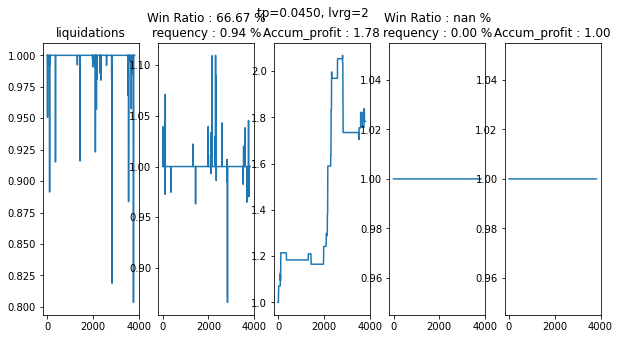

len(ohlc) : 3824
long_ep.shape : (3824, 1)
len(pr_list) : 3824
np.array(data_x).shape : (36, 5, 6)
input_x.shape : (36, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (36, 1)
input_ud.shape : (36, 1)
total_x.shape : (3920, 5, 6, 3)
total_pr.shape : (3920, 1)
total_ud.shape : (3920, 1)
-------------- 2021-02-11 ATOMUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

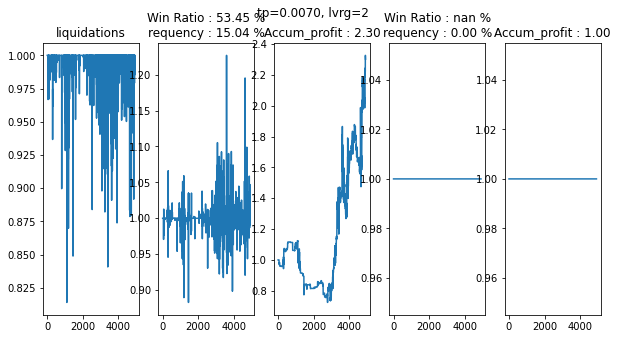

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (739, 5, 6)
input_x.shape : (739, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (739, 1)
input_ud.shape : (739, 1)
total_x.shape : (4659, 5, 6, 3)
total_pr.shape : (4659, 1)
total_ud.shape : (4659, 1)
-------------- 2021-02-11 EOSUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

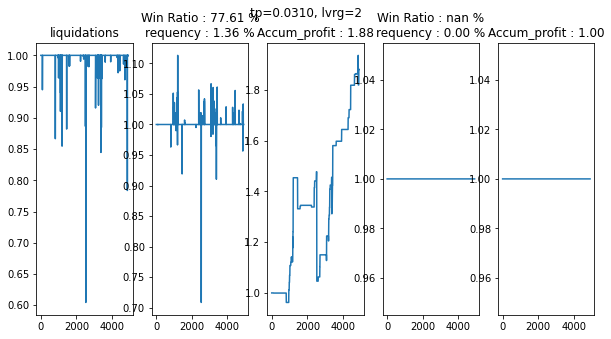

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (67, 5, 6)
input_x.shape : (67, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (67, 1)
input_ud.shape : (67, 1)
total_x.shape : (4726, 5, 6, 3)
total_pr.shape : (4726, 1)
total_ud.shape : (4726, 1)
-------------- 2021-02-11 COMPUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

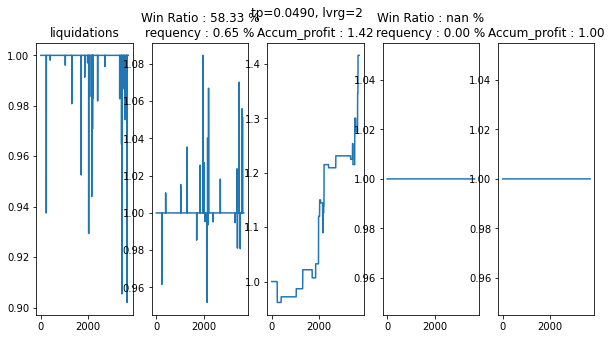

len(ohlc) : 3693
long_ep.shape : (3693, 1)
len(pr_list) : 3693
np.array(data_x).shape : (24, 5, 6)
input_x.shape : (24, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (24, 1)
input_ud.shape : (24, 1)
total_x.shape : (4750, 5, 6, 3)
total_pr.shape : (4750, 1)
total_ud.shape : (4750, 1)
-------------- 2021-02-11 KAVAUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

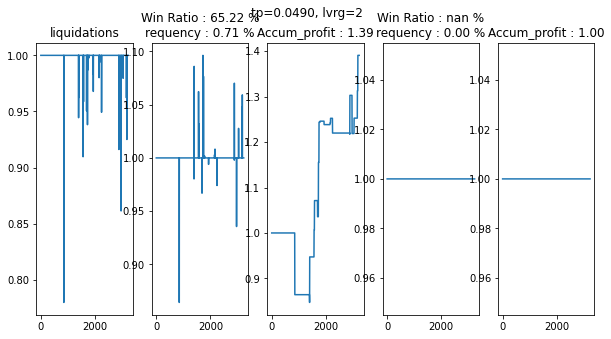

len(ohlc) : 3237
long_ep.shape : (3237, 1)
len(pr_list) : 3237
np.array(data_x).shape : (23, 5, 6)
input_x.shape : (23, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (23, 1)
input_ud.shape : (23, 1)
total_x.shape : (4773, 5, 6, 3)
total_pr.shape : (4773, 1)
total_ud.shape : (4773, 1)
-------------- 2021-02-11 ONTUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

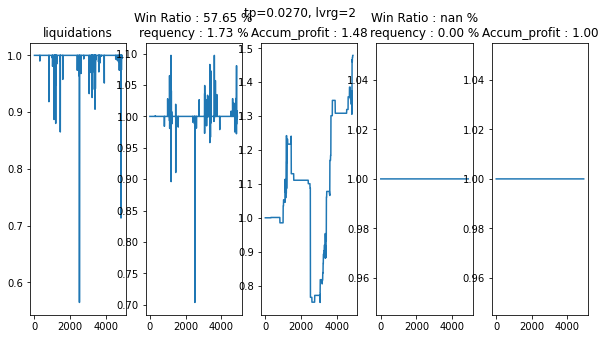

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (85, 5, 6)
input_x.shape : (85, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (85, 1)
input_ud.shape : (85, 1)
total_x.shape : (4858, 5, 6, 3)
total_pr.shape : (4858, 1)
total_ud.shape : (4858, 1)
-------------- 2021-02-11 XRPUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

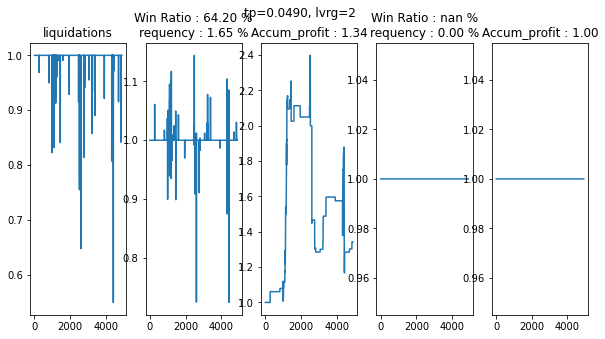

len(ohlc) : 4913
long_ep.shape : (4913, 1)
len(pr_list) : 4913
np.array(data_x).shape : (81, 5, 6)
input_x.shape : (81, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (81, 1)
input_ud.shape : (81, 1)
total_x.shape : (4939, 5, 6, 3)
total_pr.shape : (4939, 1)
total_ud.shape : (4939, 1)
-------------- 2021-02-11 MKRUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

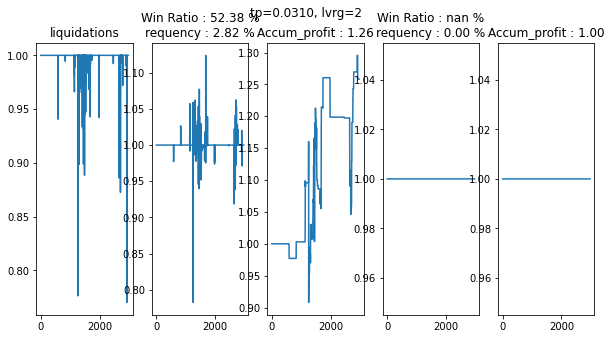

len(ohlc) : 2976
long_ep.shape : (2976, 1)
len(pr_list) : 2976
np.array(data_x).shape : (84, 5, 6)
input_x.shape : (84, 5, 6, 3)
input_x.dtype : float32
input_pr.shape : (84, 1)
input_ud.shape : (84, 1)
total_x.shape : (5023, 5, 6, 3)
total_pr.shape : (5023, 1)
total_ud.shape : (5023, 1)


In [13]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler


leverage = 2
prev_x = None
for i in range(len(candis)):

  keys = [candis[i]]
  
  # if 'algo'.upper() not in candis[i]:
  #   continue
  if '2021-03-02 DOTUSDT.xlsx' in candis[i]:
    # print('')
    continue

  # plt.figure(figsize=(35, 10))
  # plt.suptitle('%s %s' % (interval, keys))


  #         get tp parameter        #

  # plt.subplot(1,10,3)
  # for key in keys:  
  #   # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['ap_list'])
  #   argmax = np.argmax(profit_result_dict[key]['ap_list'][:, [long_index]])
  #   peak_tp = profit_result_dict[key]['tp_list'][argmax]
  #   # plt.axvline(peak_tp, linestyle='--')
  #   # plt.title('acc profit, max at %.4f' % (peak_tp))  

  # plt.subplot(1,10,4)
  # plt.title('max acc profit by leverage')  
  for key in keys:  
    # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['max_ap_list'], label=key)
    argmax = np.argmax(profit_result_dict[key]['max_ap_list'][:, [long_index]])
    max_peak_tp = profit_result_dict[key]['tp_list'][argmax]
    # plt.axvline(max_peak_tp, linestyle='--')
    # plt.title('max acc profit, max at %.4f' % (max_peak_tp))  


  for key in keys:  
    # print(profit_result_dict[key]['leverage_ap_list'])

    for tp in [max_peak_tp]:

      # if tp == peak_tp:
      #   plt.subplot(1,10,5)
      # else:
      #   plt.subplot(1,10,6)

      #     leverage analysis     #
      ohlcv = profit_result_dict[key]['ohlcv']
      predictions = profit_result_dict[key]['predictions']
      err_ranges = profit_result_dict[key]['err_ranges']

      # predictions = ohlcv['close'].shift(1).values
      # err_ranges = np.zeros_like(predictions)

      leverage_list = profit_result_dict[key]['leverage_list']
      # temp_ap_list = list()
      # temp_pr_list = list()

      try:
        print('-------------- %s --------------' % key)
        result = get_back_result(ohlcv, predictions, err_ranges, tp=tp, leverage=leverage, show_plot=True, reverse_short=False, show_detail=False)
        # temp_ap_list.append(result[2])
        # temp_pr_list.append(result[3])

        # if round(leverage) == 1:
        #   temp_pr_list = result[3]
        pr_list = result[3][long_index]

      except Exception as e:
        print(e)
        break    
  # break


      pd.set_option('display.max_rows', 500)
      pd.set_option('display.max_columns', 500)
      pd.set_option('display.width', 1000)

      #         clustering zone           #

      #       set data features : ohlc, v, ep
      ohlc = ohlcv.iloc[-len(predictions):, :4]
      vol = ohlcv.iloc[-len(predictions):, [4]]
      long_ep = (np.array(predictions) - np.array(err_ranges)) * (1 / (tp + 1))
      long_ep = long_ep.reshape(-1, 1)

      ohlcv['u_wick'] = ohlcv['high'] / np.maximum(ohlcv['close'] , ohlcv['open'])
      ohlcv['d_wick'] = np.minimum(ohlcv['close'] , ohlcv['open']) / ohlcv['low']
      ohlcv['body'] = ohlcv['close'] / ohlcv['open']

      candle = ohlcv.iloc[-len(predictions):, -3:]


      print('len(ohlc) :', len(ohlc))
      print('long_ep.shape :', long_ep.shape)
      print('len(pr_list) :', len(pr_list))


      #       set params    #
      period = 5
      data_x, data_pr, data_updown = [], [], []
      key_i = i

      for i in range(period, len(predictions)):

        #   pr_list != 1 인 데이터만 사용한다
        # if 1:
        if pr_list[i] != 1:
          
          #   prediction 을 제외한 이전 데이터를 사용해야한다
          temp_ohlc = ohlc.iloc[i - period : i].values
          temp_long_ep = long_ep[i - period : i]
          temp_vol = vol.iloc[i - period : i].values
          temp_candle = candle.iloc[i - period : i].values

          # print(temp_ohlc.shape)
          # print(temp_long_ep.shape)
          # print(temp_vol.shape)
          # print(temp_candle.shape)
          # break

          #   stacking  
          # temp_data = np.hstack((temp_ohlc, temp_long_ep, temp_vol, temp_candle))
          temp_data = np.hstack((temp_ohlc, temp_long_ep, temp_vol))
          # temp_data = np.hstack((temp_ohlc, temp_long_ep))
          # temp_data = temp_vol

          #   scaler 설정

          #   ohlc & ep -> max_abs
          # max_abs = MaxAbsScaler()
          # temp_data[:, :5] = max_abs.fit_transform(temp_data[:, :5])


          min_max = MinMaxScaler()
          temp_data[:, :5] = min_max.fit_transform(temp_data[:, :5])


          #   vol -> min_max
          min_max = MinMaxScaler()
          temp_data[:, [5]] = min_max.fit_transform(temp_data[:, [5]])


          #   candle -> max_abs    
          # max_abs = MaxAbsScaler()
          # temp_data[:, -3:] = max_abs.fit_transform(temp_data[:, -3:])

          # min_max = MinMaxScaler()
          # temp_data[:, -3:] = min_max.fit_transform(temp_data[:, -3:])

          if np.isnan(np.sum(temp_data)):
            continue

          data_x.append(temp_data)
          data_pr.append(pr_list[i])
          data_updown.append(ohlc['close'].iloc[i] / ohlc['open'].iloc[i])


      print('np.array(data_x).shape :', np.array(data_x).shape)
      # print(data_x[0])


      #       Reshape data for image deep - learning     #
      _, row, col = np.array(data_x).shape

      input_x = np.array(data_x).reshape(-1, row, col, 1).astype(np.float32)

      #     1c to 3c    #
      input_x = input_x * np.ones(3, dtype=np.float32)[None, None, None, :]

      input_pr = np.array(data_pr).reshape(-1, 1).astype(np.float32)
      input_ud = np.array(data_updown).reshape(-1, 1).astype(np.float32)
      print('input_x.shape :', input_x.shape)
      print('input_x.dtype :', input_x.dtype)
      print('input_pr.shape :', input_pr.shape)
      print('input_ud.shape :', input_ud.shape)

      #     do stacking   #
      if prev_x is None:
        prev_x = input_x
        prev_pr = input_pr
        prev_ud = input_ud
      else:
        total_x = np.vstack((prev_x, input_x))
        total_pr = np.vstack((prev_pr, input_pr))
        total_ud = np.vstack((prev_ud, input_ud))

        prev_x = total_x
        prev_pr = total_pr
        prev_ud = total_ud

        print('total_x.shape :', total_x.shape)
        print('total_pr.shape :', total_pr.shape)
        print('total_ud.shape :', total_ud.shape)
        

(5023, 12, 10, 3)
pr_train[:5] : [[1.0023471 ]
 [0.9930571 ]
 [0.99234784]
 [1.0530945 ]
 [0.9987999 ]]
ud_train[:5] : [[0.96421266]
 [0.98199445]
 [0.96006846]
 [0.9890425 ]
 [0.97732556]]
y_train[:5] : [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
y_train.dtype : float32
x_train.shape : (3013, 12, 10, 3)
x_test.shape : (1005, 12, 10, 3)
x_val.shape : (1005, 12, 10, 3)
y_train.shape : (3013, 1)
y_test.shape : (1005, 1)
y_val.shape : (1005, 1)
np.unique(y_train, return_counts=True : (array([0., 1.], dtype=float32), array([2749,  264])) [10.41287879  1.        ]
np.unique(y_val, return_counts=True : (array([0., 1.], dtype=float32), array([913,  92])) [9.92391304 1.        ]
np.unique(y_test, return_counts=True : (array([0., 1.], dtype=float32), array([918,  87])) [10.55172414  1.        ]
class_weights : {0: 0.5480174608948709, 1: 5.706439393939394}
sample_weight[:20] : [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.5 1.  1.  1.  1.
 1.  1. ]
np.isnan(np.sum(x_train)) : False
np.isnan(np.sum(x

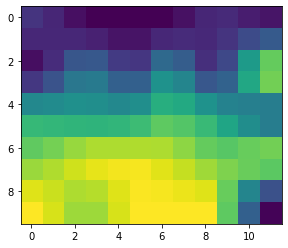

(12, 10, 3)
set_[:, :, 0] : [[0.         0.         0.         0.         0.00155642 0.00622568
  0.00466926 0.         0.         0.        ]
 [0.03560831 0.03425807 0.03223271 0.03088441 0.0253503  0.01144458
  0.01836026 0.03568664 0.03934582 0.04178527]
 [0.15430269 0.14845163 0.13967507 0.13383245 0.10466325 0.02884092
  0.06399694 0.15464212 0.17049858 0.18106952]
 [0.27299705 0.26264518 0.2471174  0.23678048 0.18397619 0.04623725
  0.10963361 0.27359757 0.3016513  0.32035375]
 [0.28152817 0.2659295  0.24253145 0.18696922 0.13672236 0.09710617
  0.16206747 0.27931744 0.27354524 0.26969704]
 [0.27781898 0.25689054 0.2254979  0.12018471 0.07540552 0.15169427
  0.21525656 0.27245557 0.22774372 0.19793579]
 [0.34582093 0.30791184 0.2510482  0.14449441 0.11445751 0.23745432
  0.30270088 0.3390722  0.24373052 0.18016936]
 [0.48553413 0.41899344 0.3191824  0.2598984  0.2538784  0.35438642
  0.42440045 0.47916746 0.32150567 0.21639779]
 [0.6274728  0.5390099  0.40631557 0.39027193 0.4052

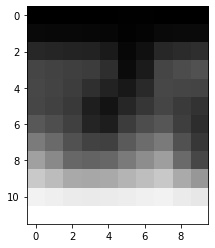

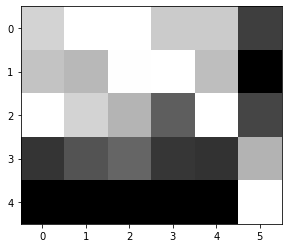

In [20]:
import keras
import tensorflow as tf

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


from sklearn.utils.testing import all_estimators
from sklearn.metrics import accuracy_score, classification_report

from functools import partial
from sklearn.utils import class_weight
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
import cv2


seed = 1
random_state = 203
np.random.seed(seed)
tf.random.set_seed(seed)

#         resize total_x shape  (, 5, 6, 3)      #
# .repeat(2, axis=0).repeat(2, axis=1)
temp_x = list()
for data in total_x:
  resized_data = cv2.resize(data, (row * 2, col * 2))
  # cmapped = plt.cm.Set1(resized_data)[:, :, :3]  # Drop Alpha Channel
  temp_x.append(resized_data)

re_total_x = np.array(temp_x)
print(re_total_x.shape)

#         train / test split      #
x_train, x_test_, pr_train, pr_test_, ud_train, ud_test_ = train_test_split(re_total_x, total_pr, total_ud, test_size=0.4, shuffle=True, random_state=random_state)
x_test, x_val, pr_test, pr_val, ud_test, ud_val = train_test_split(x_test_, pr_test_, ud_test_, test_size=0.5, shuffle=True, random_state=random_state)


#         pr label   #
# y_train = np.where(pr_train > 1, 1, 0).astype(np.float32)
# y_test = np.where(pr_test > 1, 1, 0).astype(np.float32)
# y_val = np.where(pr_val > 1, 1, 0).astype(np.float32)

#         up label      #
y_train = np.where(ud_train > 1, 1, 0).astype(np.float32)
y_test = np.where(ud_test > 1, 1, 0).astype(np.float32)
y_val = np.where(ud_val > 1, 1, 0).astype(np.float32)

print('pr_train[:5] :', pr_train[:5])
print('ud_train[:5] :', ud_train[:5])
print('y_train[:5] :', y_train[:5])
print('y_train.dtype :', y_train.dtype)

print('x_train.shape :', x_train.shape)
print('x_test.shape :', x_test.shape)
print('x_val.shape :', x_val.shape)
print('y_train.shape :', y_train.shape)
print('y_test.shape :', y_test.shape)
print('y_val.shape :', y_val.shape)

def class_ratio(in_list):

  return in_list / in_list[1]

print('np.unique(y_train, return_counts=True :', np.unique(y_train, return_counts=True), class_ratio(np.unique(y_train, return_counts=True)[1]))
print('np.unique(y_val, return_counts=True :', np.unique(y_val, return_counts=True), class_ratio(np.unique(y_val, return_counts=True)[1]))
print('np.unique(y_test, return_counts=True :', np.unique(y_test, return_counts=True), class_ratio(np.unique(y_test, return_counts=True)[1]))

label = y_train.reshape(-1, )
class_weights = class_weight.compute_class_weight('balanced', 
                                                    classes=np.unique(label),
                                                    y=label)
class_weights = dict(enumerate(class_weights))
print('class_weights :', class_weights)

sample_weight = np.ones(shape=(len(y_train),))
sample_weight[(y_train == 1).reshape(-1,)] = 1.5
print('sample_weight[:20] :', sample_weight[:20])


print('np.isnan(np.sum(x_train)) :', np.isnan(np.sum(x_train)))
print('np.isnan(np.sum(x_val)) :', np.isnan(np.sum(x_val)))
print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
print('np.isnan(np.sum(y_train)) :', np.isnan(np.sum(y_train)))
print('np.isnan(np.sum(y_val)) :', np.isnan(np.sum(y_val)))
print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))


train_set_ = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_set_ = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_set_ = tf.data.Dataset.from_tensor_slices((x_val, y_val))

resize_shape = [row * 2, col * 2]
# resize_shape = [224, 224]

def preprocess(image, label, flip=False):
  if flip:
      flipped_image = tf.image.random_flip_left_right(image)
      resized_image = tf.image.resize(flipped_image, resize_shape)
  else:
      resized_image = tf.image.resize(image, resize_shape)
  final_image = keras.applications.xception.preprocess_input(resized_image * 255)
  return  final_image, label

# Batch Size
batch_size = 32

train_set = train_set_.shuffle(1000).repeat(2)
train_set = train_set.map(partial(preprocess, flip=False)).batch(batch_size).prefetch(1)
val_set = val_set_.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_.map(preprocess).batch(batch_size).prefetch(1)

for set_ in train_set:
  print(set_[0].numpy()[0].shape)
  # print('set[0].numpy()[0, :, :, 0] :', set[0].numpy()[0, :, :, 0])
  plt.imshow(set_[0].numpy()[0, :, :, 0])
  plt.show()
  break


for set_ in x_train:
  print(set_.shape)
  print('set_[:, :, 0] :', set_[:, :, 0])
  plt.imshow(set_)
  plt.show()
  plt.imshow(data)
  plt.show()
  break

#### **DL**

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
# print(base_model.summary())
# take the average of each feature map for dimensionality reduction 
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
# softmax class probability layer with the chosen 30 categories
output = keras.layers.Dense(2, activation="softmax")(avg)
# output = keras.layers.Dense(2)(avg)
# output = keras.layers.Dense(2, activation="softmax")(base_model.output)
# combining the base model and the customized top layers 

In [ ]:
# for layer in base_model.layers:
#     # print(layer.name)
#     layer.trainable = False

# # training the top layers
# optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
# model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
#               metrics=["accuracy"])
# history = model.fit(train_set, epochs=1000, validation_data=val_set)
# score = model.evaluate(test_set)

In [ ]:
from keras.models import Model
import keras.layers as layers


def custom_model(input_shape=(row, col, 3)):
    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    net = layers.Conv2D(256, kernel_size=3, padding='same')(visible)
    # net = layers.BatchNormalization()(net)
    net = layers.LeakyReLU()(net)

    net = layers.Conv2D(128, kernel_size=3, padding='same')(net)
    # net = layers.BatchNormalization()(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_1 = net

    net = layers.Conv2D(64, kernel_size=3, padding='same')(net)
    net = layers.LeakyReLU()(net)

    net = layers.Conv2D(32, kernel_size=3, padding='same')(net)
    # net = layers.BatchNormalization()(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.Dropout(0.3)(net)
    # net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_2 = net

#     net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

#     shortcut_3 = net

#     net = layers.Conv2D(128, kernel_size=1, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

    net = layers.Flatten()(net)
    net = layers.Dense(128)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(64)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(1, activation='softmax')(net)

    # create model 
    model = Model(inputs=visible, outputs=net)
    # summary layers
    # print(model.summary())
    
    return model

In [ ]:
keras.backend.clear_session()

import gc

try:
  del model
  gc.collect()
except:
  pass

# unfreeze the weights of the pre trained layers
for layer in base_model.layers:
    layer.trainable = True
# training the whole layers
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
# optimizer = keras.optimizers.Adam(learning_rate=0.001,
#                                  decay=0.001)
model = keras.models.Model(inputs=base_model.input, outputs=output)
# model = custom_model(input_shape=(resize_shape[0], resize_shape[1], 3))
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
# model.compile(loss="categorical_crossentropy", optimizer=optimizer,
#               metrics=["accuracy"])
# save best performance on the validation set

ckpt_path = current_path + 'ckpt/'
board_path = current_path + 'graph/'

model_name = 'classifier_%s_min_re.h5' % period
# model_name = 'classifier_%s_min.h5' % period

checkpoint_cb = keras.callbacks.ModelCheckpoint(ckpt_path + model_name, 
                                                save_best_only=True, 
                                                monitor='val_loss',
                                                mode='auto')
# interrupt the training when there is no progress on the validation set for 10 epocs
early_stopping_cb = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)
#view the learning curves during training using tensorboard
tensorboard_cb = keras.callbacks.TensorBoard(board_path)
history = model.fit(train_set, epochs=1000, 
                    class_weight=class_weights,
                    # sample_weight=sample_weight,
                    validation_data=val_set, 
                    shuffle=False,
                    # callbacks=[checkpoint_cb, early_stopping_cb])
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/1000
1507/1507 [==============================] - 60s 27ms/step - loss: 0.9960 - accuracy: 0.5113 - val_loss: 0.7547 - val_accuracy: 0.0886
Epoch 2/1000
1507/1507 [==============================] - 37s 24ms/step - loss: 0.7065 - accuracy: 0.5042 - val_loss: 0.6298 - val_accuracy: 0.9114
Epoch 3/1000
1507/1507 [==============================] - 37s 24ms/step - loss: 0.6987 - accuracy: 0.5985 - val_loss: 0.6794 - val_accuracy: 0.9114
Epoch 4/1000
1507/1507 [==============================] - 36s 24ms/step - loss: 0.6825 - accuracy: 0.6251 - val_loss: 0.6220 - val_accuracy: 0.9114
Epoch 5/1000
1507/1507 [==============================] - 36s 24ms/step - loss: 0.6963 - accuracy: 0.6652 - val_loss: 0.6631 - val_accuracy: 0.9114
Epoch 6/1000
1507/1507 [==============================] - 36s 24ms/step - loss: 0.6926 - accuracy: 0.7274 - val_loss: 0.6487 - val_accuracy: 0.9114
Epoch 7/1000
1507/1507 [==============================] - 36s 24ms/step - loss: 0.7041 - accuracy: 0.6471 - val_

KeyboardInterrupt: ignored

In [ ]:
# model_name = "classifier_5_min_re.h5"  # <-- specifying model name
model = keras.models.load_model(ckpt_path + model_name)

In [ ]:
# model.evaluate(val_set)

test_result.shape : (1005, 2)
pr_val.shape : (1005, 1)
y_test[:5] : [0. 0. 0. 0. 0.]
np.unique(y_test) : (array([0., 1.], dtype=float32), array([914,  91]))
y_score[:5] : [[0.4543802]
 [0.4543802]
 [0.4543802]
 [0.4543802]
 [0.4543802]]
np.unique(y_score) : (array([0.4543802], dtype=float32), array([1005]))
y_test.shape : (1005, 1)
y_score.shape : (1005, 1)


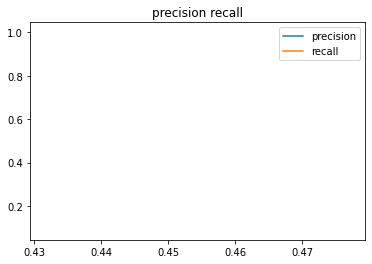

threshold : [0.4543802]
y_pred.shape : (1005,)
precision : 0.0
recall : 0.0

np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_test)) : False

origin ac_pr : 1378.8969
win ratio improvement 0.09 --> nan
acc_pr_bythr : [1.0]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in long_scalars


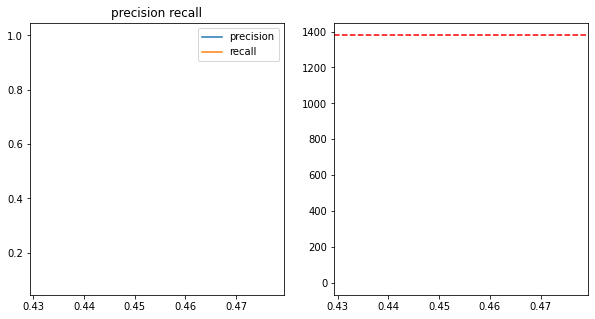

In [ ]:
test_result = model.predict(test_set)

print('test_result.shape :', test_result.shape)
print('pr_val.shape :', pr_val.shape)


y_score = test_result[:, [1]]
print('y_test[:5] :', y_test.reshape(-1,)[:5])
print('np.unique(y_test) :', np.unique(y_test, return_counts=True))
print('y_score[:5] :', y_score[:5])
print('np.unique(y_score) :', np.unique(y_score, return_counts=True))

print('y_test.shape :', y_test.shape)
print('y_score.shape :', y_score.shape)

#     precision recall curve   #
precision, recall, threshold = precision_recall_curve(y_test, y_score)
precision, recall = precision[:-1], recall[:-1]

plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.legend()
plt.title('precision recall')
plt.show()
# print(y_pred)

# thresh = 0.19
# threshold = [thresh]
print('threshold :', threshold)

acc_pr_bythr = []
for thresh in threshold:

  y_pred = np.where(y_score[:, -1] > thresh, 1, 0)
  print('y_pred.shape :', y_pred.shape)
  # print('y_pred :', y_pred)

  #     compare precision     #

  print('precision :', precision_score(y_test, y_pred))
  print('recall :', recall_score(y_test, y_pred))
  print()

  print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
  print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

  # plot_confusion_matrix(best_model, x_test, y_test, normalize=None)
  # plt.show()  
  print()

  #     check win-ratio improvement     #
  cmat = confusion_matrix(y_test, y_pred)
  # print(cmat)
  # print(np.sum(cmat, axis=1))

  test_size = len(y_test)
  test_pr_list = pr_test
  print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

  org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
  ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
  print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

  # print('pr_test.shape :', pr_test.shape)

  # print(y_pred)
  # print(test_pr_list)
  pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1.0)
  # print('pred_pr_list.shape :', pred_pr_list.shape)

  if np.cumprod(test_pr_list)[-1] < np.cumprod(pred_pr_list)[-1]:
    print('accum_pr increased ! : %.3f --> %.3f' % (np.cumprod(test_pr_list)[-1], np.cumprod(pred_pr_list)[-1]))
    print('thresh :', thresh)
    
  # if len(threshold) == 1:
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(np.cumprod(test_pr_list))
    plt.title('%.3f' % (np.cumprod(test_pr_list)[-1]))
  # plt.show()

    plt.subplot(122)
    plt.plot(np.cumprod(pred_pr_list))
    plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
    plt.show()


  acc_pr_bythr.append(np.cumprod(pred_pr_list)[-1])

print('acc_pr_bythr :', acc_pr_bythr)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.legend()
plt.title('precision recall')
# plt.show()
plt.subplot(122)
plt.plot(threshold, acc_pr_bythr)
plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
plt.show()

#### **clustering output**

[[0.7037145  0.2962855 ]
 [0.9288634  0.07113659]
 [0.95626485 0.0437351 ]
 [0.9838307  0.01616931]
 [0.95609605 0.04390394]
 [0.9687496  0.03125039]
 [0.9770198  0.02298024]
 [0.98615426 0.01384575]
 [0.97876215 0.02123786]
 [0.7286876  0.27131242]]
x_train.shape : (1003, 2)
pr_train.shape : (1003, 1)


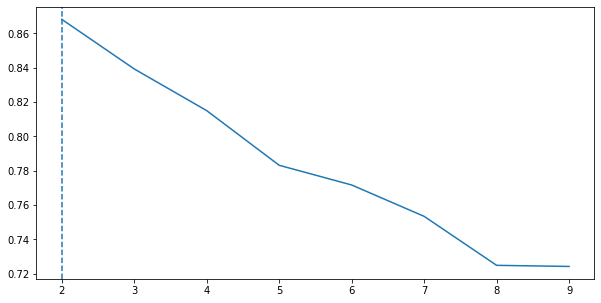

-18.73578
1003 1003
{0: [], 1: []}
{0: [1.0118026, 0.9021246, 0.99546266, 1.0934155, 1.075943, 1.0834613, 0.9729715, 0.9675816, 0.9926733, 0.94246113, 1.0383651, 0.9980204, 1.0033829, 0.99806654, 1.0304593, 1.0137182, 1.1429349, 1.0051354, 1.0168538, 1.0024531, 0.9976732, 1.0033841, 1.0132998, 1.0246147, 1.0050453, 1.0520307, 1.0288537, 0.9944408, 1.020657, 1.0441729, 1.0060083, 0.97945267, 0.9167471, 0.9640037, 1.0277942, 0.8871045, 0.99148023, 1.0278138, 0.90256006, 1.0279776, 0.9758551, 1.028992, 0.99377537, 0.9932176, 1.0872195, 0.98981327, 0.9981634, 1.0144947, 0.98451424, 0.9807681, 1.0166186, 0.9854618, 1.0928899, 1.1118702, 0.9685919, 0.9772424, 0.9553785, 1.068521, 0.99992, 0.9840308, 0.99727577, 0.9645231, 1.0036368, 1.0327321, 1.0409007, 1.0887885, 1.0042193, 1.0258725, 0.94682586, 0.931009, 1.0210526, 0.9959011, 1.0981361, 1.0134593, 1.0582548, 0.971626, 1.0008532, 0.9758551, 1.046691, 0.9969557, 0.9843974, 1.0315255, 0.95291805, 1.023045, 1.0343238, 0.98965406, 1.0268687, 

In [ ]:
# x_train = test_result.flatten().reshape(-1, 1)
x_train = test_result
print(x_train[:10])
# x_train = test_result[:, [1]]
pr_train = pr_test

print('x_train.shape :', x_train.shape)
print('pr_train.shape :', pr_train.shape)

K = range(2, 10)
s_dist = []
sil = []
for k in K:
  # if cen_data.shape[0] < k:
  #   break

  km = KMeans(n_clusters=k)
  km = km.fit(x_train)

  labels = km.labels_
  # print('len(labels) :', len(labels))
  # print('labels[:10] :', labels[:10])
  sil.append(silhouette_score(x_train, labels, metric='euclidean'))

  # inertia = km.inertia_
  # s_dist.append(inertia)

best_k = K[np.argmax(np.array(sil))]

plt.figure(figsize=(10, 5))
plt.plot(K, sil)
plt.axvline(best_k, linestyle='--')
# plt.plot(K, s_dist)
plt.show()





#   with best_k, label 별 pr_list 확인
km = KMeans(n_clusters=best_k)
km = km.fit(x_train)

labels = km.labels_

print(km.score(x_train))
print(len(labels), len(pr_train))





#   label 별로 profit 을 저장, 승률을 확인한다
label_types = np.unique(labels, return_counts=False)

label_pr_dict = {}
#   init dict   #
for label in label_types:
  label_pr_dict[label] = []
print(label_pr_dict)
# break

for i, (label, pr) in enumerate(zip(labels, pr_train)):
  label_pr_dict[label].append(pr[0])

  
# for label in label_types:
print(label_pr_dict)





def win_ratio(list_x):

  win_cnt = np.sum(np.array(list_x) > 1)
  return win_cnt / len(list_x)


def acc_pr(list_x):

  return np.cumprod(np.array(list_x))[-1]


for key in label_pr_dict:
  
  print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))





#     predict test && test 의 라벨에 따른 win_ratio 확인
# test_labels = km.predict(x_test)
# # print(test_labels)

# label_pr_dict = {}
# #   init dict   #
# for label in label_types:
#   label_pr_dict[label] = []
# print(label_pr_dict)
# # break

# for i, (label, pr) in enumerate(zip(test_labels, pr_test)):
#   label_pr_dict[label].append(pr[0])

# for key in label_pr_dict:

#   print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))

